In [85]:
!pip install pyarrow

## Описание и задачи исследования

# Цель исследования

Определить временные периоды, когда недостаточно водителей, т.е. наблюдается дефицит предложения, предложить меры стимулирования предложения и оценить их эффективность.

# Описание данных

Файл `Taxi_data.ftr`:

Столбцы:

* `Trip Start Timestamp` — дата и время начала поездки;
* `Trip End Timestamp` — дата и время окончания поездки;
* `Trip Seconds` — продолжительность поездки в секундах;
* `Trip Miles` — расстояние, пройденное во время поездки в милях;
* `Pickup Community Area` — зона, где был подобран клиент;
* `Dropoff Community Area` — зона, где был высажен клиент;
* `Fare` — сумма тарифа, взимаемая за поездку в долларах;
* `Tips` — сумма чаевых за поездку;
* `Tolls` — сумма, уплачиваемая во время поездки (за платные дороги);
* `Extras` — Дополнительные сборы за поездку;
* `Trip Total` — общая сумма оплаты за поездку;
* `Payment Type` — Тип оплаты поездки;
* `Company` — Компания такси, связанная с поездкой;
* `Pickup Centroid Latitude, Pickup Centroid Longitude, Dropoff Centroid Latitude, Dropoff Centroid Longitude` — координаты центров кластеров посадки/высадки;
* `Taxi ID` — Уникальный идентификатор такси.

Этот набор данных предоставляет ценную информацию для анализа поездок такси, включая продолжительность, расстояние, оплату и географические координаты мест посадки и высадки. Его можно использовать для получения информации о моделях использования такси, распределении платы за проезд, популярных местах посадки/высадки и многом другом.

Файл `Taxi_data.ftr`:

Столбцы:

* `Hour Trip Start` — час начала поездки;
* `Estimated coverage` — расчётная величина покрытия машинами.

Рассчитанная на основании данных доля уникальных клиентов в этот час, которым был предложен вариант поездки по запросу (даже если они не воспользовались услугой).

# Источник данных

В датасете представлены данные по совершенным заказам такси агрегатора Bolt в городе Чикаго.  
Источник: data.cityofchicago.org

# Задачи исследования

Этапы проекта:
> &nbsp;
> 1. Подготовьте данные для анализа
> >  * Найти аномалии в данных, принять решение о их сохранении или отбрасывании
> 2. Рассчитайте для каждого часа:
> >  * Количество машин на линии (только по данным начала поездок)
> >  * Количество поездок
> >  * Среднюю длительность поездки
> >  * Среднюю длинну поездки
> >  * Среднюю тарифную стоимость поездки
> >  * Иные показатели, включая показатели из расчёта на одного водителя, включая общую выручку и выручку водителя (исходя из того, что водитель получает 60% тарифа за поездку и все чаевые)
> 3. Определите периоды когда водители получают
> >  * выручку исходя из тарифа ниже среднего
> >  * меньше чаевых
> 4. Определите критические периоды дефицита предложения
> >  * рассчитайте оптимальное число машин на линии для обеспечения нормального показателя покрытия
> 5. Визуализируйте найденные в п.4 и важные рассчитанные ранее показатели с учётом недельных и суточных циклов
>
> 6. Определите периоды, в которые меры стимулирования предложения услуг такси нужны и будут наиболее эффективны
>
> 7. В рамках определённых в п.6 периодов оцените:
> >  * объём недополученной общей выручки из-за низкого предложения
> >  * дефицит количества машин на линии (сколько нужно вывести машин дополнительно, чтобы достичь нормального покрытия)
> 8. (опционально) Предложите меры стимулирования предложения и оцените их эффективность
>
> 9. Подготовьте презентацию на 7-10 слайдов с основными результатами проекта.
> &nbsp;<br><br>

# Открытие данных

In [86]:
import pandas as pd
import numpy as np
from decimal import Decimal
import scipy.stats as stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

pd.pandas.set_option('display.max_columns', None) #отобразим все колонки таблицы
#округлим числовые значения до сотых, дабы избержать экспоненциального формата данных
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams["axes.formatter.limits"] = (-99, 99) #disable scientific notation on axes
plt.rcParams["figure.figsize"] = (18, 10)

In [87]:
#df = pd.read_feather('Taxi_data.ftr')
#df_cover = pd.read_feather('Estimated_coverage.ftr')

In [88]:
#Код ревьюера - подгружаю данные
try:
    raw_df = pd.read_feather('Taxi_data.ftr')
    raw_df_cover = pd.read_feather('Estimated_coverage.ftr')
except:
    raw_df = pd.read_feather('https://drive.google.com/uc?id=1AUo5eQ77sj0HgNCoHHPE5XdtachQ3EEl')
    raw_df_cover = pd.read_feather('https://drive.google.com/uc?id=1YVfhEKrDuDj3LuEocEhYgLpYx36PW4LB')

In [89]:
raw_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826887 entries, 0 to 1826886
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip Start Timestamp        1826887 non-null  datetime64[ns]
 1   Trip End Timestamp          1826887 non-null  datetime64[ns]
 2   Trip Seconds                1826871 non-null  float64       
 3   Trip Miles                  1826883 non-null  float64       
 4   Pickup Community Area       1602394 non-null  float64       
 5   Dropoff Community Area      1568478 non-null  float64       
 6   Fare                        1826885 non-null  float64       
 7   Tips                        1826885 non-null  float64       
 8   Tolls                       1826885 non-null  float64       
 9   Extras                      1826885 non-null  float64       
 10  Trip Total                  1826885 non-null  float64       
 11  Payment Type            

In [90]:
raw_df_cover.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Hour Trip Start     1413 non-null   datetime64[ns]
 1   Estimated coverage  1411 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB


Выведем на экран 5 случайных строк каждой из таблиц:

In [91]:
raw_df.sample(5)

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Taxi ID
1006229,2015-03-10 10:45:00,2015-03-10 11:00:00,540.00,1.50,32.00,8.00,7.25,0.00,0.00,0.00,7.25,Cash,Dispatch Taxi Affiliation,41.88,-87.63,41.90,-87.65,144
150929,2015-02-08 11:30:00,2015-02-08 11:30:00,300.00,0.00,8.00,8.00,5.25,1.00,0.00,0.00,6.25,Credit Card,Taxi Affiliation Services,41.89,-87.62,41.90,-87.63,809
1075123,2015-03-13 00:45:00,2015-03-13 01:00:00,660.00,3.90,8.00,24.00,10.45,0.00,0.00,0.00,10.45,Cash,Dispatch Taxi Affiliation,41.89,-87.63,41.90,-87.68,1312
123004,2015-02-12 17:45:00,2015-02-12 18:00:00,"1,560.00",12.90,56.00,8.00,27.65,7.65,0.00,3.00,38.30,Credit Card,Choice Taxi Association,41.79,-87.75,41.89,-87.61,1434
1189579,2015-03-13 23:45:00,2015-03-14 00:00:00,"1,500.00",0.70,28.00,2.00,26.05,0.00,0.00,2.00,28.05,Cash,Taxi Affiliation Services,41.89,-87.66,41.99,-87.70,318


In [92]:
raw_df_cover.sample(5)

,Hour Trip Start,Estimated coverage
555,2015-02-24 05:00:00,0.49
750,2015-03-04 08:00:00,0.76
1069,2015-03-17 17:00:00,0.75
650,2015-02-28 04:00:00,0.76
703,2015-03-02 09:00:00,0.72


Предварительно можно сказать, что в данных имеются пропуски и нулевые значения, с которыми следует разобраться, помимо этого, названия столбцов следуеет привести к «змеиному регистру».

## Предобработка данных

Проведем стандартную предобработку, включающаю проверку явных дубликатов, нулевых и пропущенных значений, а также изменим тип данных и преобразуем категориальные переменные.

Проверим данные на наличие аномалий.

Приведем возможные причины, догадки и аргументы касательно заполнения или удаления значений.

In [93]:
df = raw_df.copy()
df_cover = raw_df_cover.copy()

### Преобразование названий столбцов

In [94]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df_cover.columns = df_cover.columns.str.replace(" ", "_").str.lower()

In [95]:
df.sample()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id
1410667,2015-03-26 11:45:00,2015-03-26 11:45:00,180.00,0.40,8.00,8.00,4.45,0.00,0.00,0.00,4.45,Cash,KOAM Taxi Association,41.89,-87.62,41.90,-87.62,871


In [96]:
df_cover.sample()

,hour_trip_start,estimated_coverage
990,2015-03-14 08:00:00,0.80


### Обработка дубликатов

In [97]:
print(f"Количество явных дубликатов: {df.duplicated().sum()}. Доля: {df.duplicated().sum()/df.shape[0]:.3%}.")

Количество явных дубликатов: 1760. Доля: 0.096%.


Стоит учесть тот факт, что в массиве более **1,8** млн. строк, поэтому **1760 (0.096%)** явных дубликатов допустимы, т.к. мы имеем данные по заказам, где могут повторяться различные значения - от чаевых до расстояния или индефикатора таксиста.

In [98]:
df.nunique()

trip_start_timestamp          5565
trip_end_timestamp            5593
trip_seconds                   299
trip_miles                     687
pickup_community_area           77
dropoff_community_area          77
fare                          2086
tips                          1966
tolls                          114
extras                        1164
trip_total                    6198
payment_type                     5
company                         53
pickup_centroid_latitude       419
pickup_centroid_longitude      419
dropoff_centroid_latitude      505
dropoff_centroid_longitude     505
taxi_id                       4655
dtype: int64

In [99]:
print(f"Количество явных дубликатов: {df_cover.duplicated().sum()}. Доля: {df_cover.duplicated().sum()/df_cover.shape[0]:.3%}.")

Количество явных дубликатов: 0. Доля: 0.000%.


In [100]:
df_cover.nunique()

hour_trip_start       1413
estimated_coverage      60
dtype: int64

### Обработка пропущенных значений

Создадим таблицы с указанием доли пропусков по каждой колонке, чтобы сэкономить наше время и потом удалить пропуски или оставить их без изменений, где доля составляет не более 1%.

In [101]:
pd.concat([df.isna().sum(), df.isna().mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
trip_start_timestamp,0,0.00%
trip_end_timestamp,0,0.00%
trip_seconds,16,0.00%
trip_miles,4,0.00%
pickup_community_area,224493,12.29%
dropoff_community_area,258409,14.14%
fare,2,0.00%
tips,2,0.00%
tolls,2,0.00%
extras,2,0.00%


В некоторых столбцах присутсвуют
`pickup_community_area`, `dropoff_community_area`, `pickup_centroid_latitude`, `pickup_centroid_longitude`, `dropoff_centroid_latitude`, `dropoff_centroid_longitude` - это все данные, связанные с географическими координатами, либо расстояними определенных зон. Данные значения нас особо не интересуют, а причину пропусков можно объяснить к техническими причинам (например, отсутсвием интернета у водителя или сбоем навигатора, либо геолокация просто не определилась).

❓ **Комментарий ревьюера:** А еще были столбцы с небольшим количеством пропусков - trip_seconds, trip_miles, fare, tips, tolls, extras, trip_total - нужно ли с ними что-то делать?

In [102]:
pd.concat([df_cover.isna().sum(), df_cover.isna().mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
hour_trip_start,0,0.00%
estimated_coverage,2,0.14%


В датафрейме о покрытии машин с почасовой разбивкой все в порядке, что вполне ожидаемо, но 2 пропуска в `estimated_coverage` стоит заменить на 0, т.к. скорее всего в это время покрытие машин составило 0 единиц.

In [103]:
df_cover = df_cover.fillna(0.0)

### Обработка нулевых значений

Создадим таблицы с указанием доли нулевых значений по каждой колонке.

In [104]:
pd.concat([df.eq(0).sum(), df.eq(0).mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
trip_start_timestamp,0,0.00%
trip_end_timestamp,0,0.00%
trip_seconds,245134,13.42%
trip_miles,666195,36.47%
pickup_community_area,0,0.00%
dropoff_community_area,0,0.00%
fare,2010,0.11%
tips,1060267,58.04%
tolls,1825710,99.94%
extras,1181436,64.67%


Данные имеют немало нулевых значений, чтобы разобраться нормально это или нет — нужно выявить для каких категорий нулевые значения допустимы.

**Несвойственны для:**
- `trip_seconds` — поездка не может длиться `0 секунд`;
- `fare` — тариф поездки не может стоить `0 у.е.`;
- `trip_total` — общая стоимость поездки не может стоить `0 у.е.`;

**Свойственны для:**
- `trip_miles` — поездка может иметь длину `0 миль` (в 1 миле ~ 1,61 км.), т.к. это может быть отмененный заказ или это поездки длиной меньше 1 мили;
- `tips` — не все клиенты оставляют чаевые;
- `tolls` — далеко не каждая поездка имеет в маршруте платные дороги;
- `extras` — не все клиенты пользуются дополнительными услугами водителя (например, помощь с багажем, ожидание, детское кресло и т.п.);

Более подробно мы разберем каждую категорию из этого датафрейма в следующем шаге.

In [105]:
pd.concat([df_cover.eq(0).sum(), df_cover.eq(0).mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
hour_trip_start,0,0.00%
estimated_coverage,3,0.21%


`estimated_coverage` — расчётная величина покрытия машинами, для которой вполне допустимы нулевые значения, вероятнее всего в какие-то временные интервалы покрытие составило 0.

### Анализ данных на наличие аномальных значений

Проведем корреляционный анализ, используя функцию `describe`.

In [106]:
df.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
trip_seconds,"1,826,871.00",665.94,679.62,0.00,240.00,480.00,840.00,"80,940.00"
trip_miles,"1,826,883.00",2.17,4.74,0.00,0.00,0.60,2.00,835.20
pickup_community_area,"1,602,394.00",22.43,19.11,1.00,8.00,21.00,32.00,77.00
dropoff_community_area,"1,568,478.00",21.17,17.63,1.00,8.00,16.00,32.00,77.00
fare,"1,826,885.00",11.94,15.60,0.00,5.85,7.85,12.85,"9,449.33"
tips,"1,826,885.00",1.36,2.41,0.00,0.00,0.00,2.00,396.25
tolls,"1,826,885.00",0.00,0.15,0.00,0.00,0.00,0.00,100.00
extras,"1,826,885.00",0.84,28.10,0.00,0.00,0.00,1.00,"8,888.88"
trip_total,"1,826,885.00",14.14,32.85,0.00,6.85,9.30,14.65,"9,449.33"
pickup_centroid_latitude,"1,602,428.00",41.90,0.04,41.66,41.88,41.89,41.91,42.02


Попробуем выдвинуть гипотезы, самые сомнительные мы подвергнем проверке.  

Начнем с минимальных значений, имеющих несвойственные им нулевые значения, что скорее всего вызвано технической ошибкой при сборе данных.

Вполне вероятно, что проблема наблюдается только с определенными компаниями, для этого создадим сводную таблицу, посчитав заказы с разбивкой по компаниям.

In [107]:
(pd.pivot_table(df,
              index='company',
              values='trip_start_timestamp',
              aggfunc='count')
 .reset_index()
 .sort_values(by='trip_start_timestamp', ascending=False)
).head(10).style.background_gradient('YlGn')

,company,trip_start_timestamp
51,Taxi Affiliation Services,858021
46,Dispatch Taxi Affiliation,244192
41,Blue Ribbon Taxi Association Inc.,188178
42,Chicago Elite Cab Corp. (Chicago Carriag,166429
45,Choice Taxi Association,156183
48,Northwest Management LLC,76448
47,KOAM Taxi Association,50752
52,Top Cab Affiliation,27733
49,Suburban Dispatch LLC,17812
50,T.A.S. - Payment Only,17366


- `trip_seconds` — продолжительность поездки в секундах, доля нулевых значений составляет `13,42%`;

In [108]:
(pd
 .pivot_table(df.query('trip_seconds == 0'),
              index='company',
              values='trip_start_timestamp',
              aggfunc=['count'])
 .reset_index()
 .droplevel(1, axis=1)
 .sort_values(by='count', ascending=False)
).head(10).style.background_gradient('YlGn')

,company,count
42,Chicago Elite Cab Corp. (Chicago Carriag,161093
51,Taxi Affiliation Services,28403
49,Suburban Dispatch LLC,17733
50,T.A.S. - Payment Only,14541
46,Dispatch Taxi Affiliation,8106
41,Blue Ribbon Taxi Association Inc.,6556
45,Choice Taxi Association,3939
48,Northwest Management LLC,2596
47,KOAM Taxi Association,1072
52,Top Cab Affiliation,529


In [109]:
df['company'].unique()

['Top Cab Affiliation', 'KOAM Taxi Association', 'Taxi Affiliation Services', 'Choice Taxi Association', 'Chicago Elite Cab Corp. (Chicago Carriag', ..., '5724 - 75306 KYVI Cab Inc', '6057 - 24657 Richard Addo', '2241 - 44667 Manuel Alonso', '585 - 88805 Valley Cab Co', '3669 - 85800 Jordan Taxi Inc']
Length: 53
Categories (53, object): ['0118 - 42111 Godfrey S.Awir', '0694 - 59280 Chinesco Trans Inc',
                          '1085 - 72312 N and W Cab Co', '1247 - 72807 Daniel Ayertey', ...,
                          'Suburban Dispatch LLC', 'T.A.S. - Payment Only', 'Taxi Affiliation Services',
                          'Top Cab Affiliation']

Наше предположение подтвердилось, почти все заказы компании **Chicago Elite Cab Corp.** в датафрейме не имеют длительности поездки в секундах. Скорее всего им не интересна данная метрика, либо у них был сбой или они недавно стали собирать данные о длительности поездки.

In [110]:
zero_trips_by_companies = pd.pivot_table(df,
              index='company',
              values='trip_start_timestamp',
              aggfunc='count')\
.join(pd.pivot_table(df.query('trip_seconds == 0'),
              index='company',
              values='trip_end_timestamp',
              aggfunc='count'))\
.reset_index()\
.rename(columns={'trip_start_timestamp': 'num_trips', 'trip_end_timestamp': 'num_zero_trips'})
zero_trips_by_companies['zero_trips_share'] = zero_trips_by_companies['num_zero_trips'] / zero_trips_by_companies['num_trips']
zero_trips_by_companies.sort_values(by='zero_trips_share', ascending=False).head(20).style.format({'zero_trips_share': '{:.2%}'}).background_gradient('YlGn')

,company,num_trips,num_zero_trips,zero_trips_share
49,Suburban Dispatch LLC,17812,17733,99.56%
42,Chicago Elite Cab Corp. (Chicago Carriag,166429,161093,96.79%
50,T.A.S. - Payment Only,17366,14541,83.73%
26,4615 - 83503 Tyrone Henderson,283,25,8.83%
11,3094 - 24059 G.L.B. Cab Co,363,30,8.26%
4,1408 - 89599 Donald Barnes,124,7,5.65%
32,5129 - 98755 Mengisti Taxi,488,26,5.33%
43,Chicago Medallion Leasing INC,1430,63,4.41%
44,Chicago Medallion Management,5380,213,3.96%
41,Blue Ribbon Taxi Association Inc.,188178,6556,3.48%


In [111]:
print(f"Количество заказов, имеющих ненулевые значения: {166429 - 161093}.\n" f"Доля заказов без длительности поездки: {161093/166429:.2%}.")

Количество заказов, имеющих ненулевые значения: 5336.
Доля заказов без длительности поездки: 96.79%.


- `trip_miles` — расстояние, пройденное во время поездки в милях, доля нулевых значений составляет `36,47%`;

Вполне вероятно, что проблема снова кроется в определенных компаниях, для этого мы вновь создадим сводную таблицу.

In [112]:
(pd
 .pivot_table(df.query('trip_miles == 0'),
              index='company',
              values='trip_start_timestamp',
              aggfunc=['count'])
 .reset_index()
 .droplevel(1, axis=1)
 .sort_values(by='count', ascending=False)
).head(10).style.background_gradient('YlGn')

,company,count
51,Taxi Affiliation Services,248117
42,Chicago Elite Cab Corp. (Chicago Carriag,166429
41,Blue Ribbon Taxi Association Inc.,146672
46,Dispatch Taxi Affiliation,31954
45,Choice Taxi Association,23272
49,Suburban Dispatch LLC,17812
50,T.A.S. - Payment Only,17366
48,Northwest Management LLC,10633
47,KOAM Taxi Association,1778
52,Top Cab Affiliation,799


In [113]:
print(f"Количество заказов в Taxi Affiliation Services, имеющих ненулевые значения: {858021 - 248117}.\n" f"Доля заказов без расстояния поездки: {248117/858021:.2%}.")

Количество заказов в Taxi Affiliation Services, имеющих ненулевые значения: 609904.
Доля заказов без расстояния поездки: 28.92%.


In [114]:
df.query('company == "Taxi Affiliation Services"').sort_values(by=['taxi_id', 'trip_start_timestamp']).head(20)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id
1259027,2015-02-01 00:00:00,2015-02-01 00:00:00,600.00,0.10,24.00,22.00,8.05,0.00,0.00,1.00,9.05,Cash,Taxi Affiliation Services,41.90,-87.68,41.92,-87.68,2
1222573,2015-02-02 14:00:00,2015-02-02 14:00:00,420.00,0.10,77.00,3.00,6.85,0.00,0.00,0.00,6.85,Cash,Taxi Affiliation Services,41.99,-87.66,41.97,-87.66,2
1327576,2015-02-02 15:30:00,2015-02-02 15:45:00,720.00,0.20,24.00,28.00,10.85,2.15,0.00,0.00,13.00,Credit Card,Taxi Affiliation Services,41.90,-87.68,41.87,-87.66,2
1284773,2015-02-02 18:15:00,2015-02-02 18:30:00,"1,140.00",0.30,8.00,6.00,14.05,3.50,0.00,0.00,17.55,Credit Card,Taxi Affiliation Services,41.90,-87.62,41.95,-87.67,2
1218581,2015-02-02 18:45:00,2015-02-02 19:00:00,"1,380.00",0.30,6.00,8.00,16.05,0.00,0.00,2.00,18.05,Cash,Taxi Affiliation Services,41.94,-87.66,41.90,-87.63,2
1248429,2015-02-02 19:00:00,2015-02-02 19:30:00,"1,680.00",0.70,8.00,56.00,27.85,0.00,0.00,2.00,29.85,Cash,Taxi Affiliation Services,41.89,-87.62,41.79,-87.75,2
14410,2015-02-03 06:15:00,2015-02-03 06:30:00,"1,260.00",1.00,28.00,76.00,34.45,0.00,0.00,2.00,36.45,Cash,Taxi Affiliation Services,41.89,-87.64,41.98,-87.90,2
302938,2015-02-03 12:15:00,2015-02-03 12:30:00,540.00,0.00,32.00,8.00,7.05,2.00,0.00,0.00,9.05,Credit Card,Taxi Affiliation Services,41.88,-87.63,41.89,-87.62,2
316944,2015-02-03 12:45:00,2015-02-03 12:45:00,300.00,0.00,28.00,8.00,5.45,3.00,0.00,0.00,8.45,Credit Card,Taxi Affiliation Services,41.89,-87.64,41.89,-87.64,2
362883,2015-02-03 14:15:00,2015-02-03 14:15:00,300.00,0.00,32.00,8.00,5.85,3.00,0.00,0.00,8.85,Credit Card,Taxi Affiliation Services,41.88,-87.63,41.89,-87.62,2


Почти треть заказов компании **Taxi Affiliation Services**	в датафрейме не имеют расстояния поездки в милях. Очень вероятно, что они вызваны сбоями при сборе данных, т.к. по первым 20-ти заказам видно, что данная проблема может наблюдаться в разное время, в примерно одних и тех же зонах посадки/высадки, разныъ такси, при этом она также может и отсутсвовать при этих же параметрах.

In [115]:
print(f"Количество заказов в Chicago Elite Cab Corp., имеющих ненулевые значения: {166429 - 166429}.\n" f"Доля заказов без расстояния поездки: {166429/166429:.2%}.")

Количество заказов в Chicago Elite Cab Corp., имеющих ненулевые значения: 0.
Доля заказов без расстояния поездки: 100.00%.


Все заказы компании **Chicago Elite Cab Corp.** в датафрейме не имеют расстояния поездки. Скорее всего им не интересна данная метрика.

In [116]:
print(f"Количество заказов в Blue Ribbon Taxi Association Inc., имеющих ненулевые значения: {188178 - 146672}.\n" f"Доля заказов без расстояния поездки: {146672/188178:.2%}.")

Количество заказов в Blue Ribbon Taxi Association Inc., имеющих ненулевые значения: 41506.
Доля заказов без расстояния поездки: 77.94%.


In [117]:
df.query('company == "Blue Ribbon Taxi Association Inc."').sort_values(by=['taxi_id', 'trip_start_timestamp']).tail(6)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id
1728061,2015-03-30 20:00:00,2015-03-30 20:15:00,780.00,0.10,28.00,28.00,9.05,0.00,0.00,1.50,10.55,Cash,Blue Ribbon Taxi Association Inc.,41.89,-87.64,41.88,-87.67,3625
1728193,2015-03-30 20:30:00,2015-03-30 20:30:00,360.00,0.00,28.00,28.00,6.05,0.00,0.00,0.00,6.05,Cash,Blue Ribbon Taxi Association Inc.,41.89,-87.66,41.88,-87.64,3625
1750042,2015-03-30 20:30:00,2015-03-30 20:30:00,0.00,0.00,28.00,28.00,3.25,0.00,0.00,0.00,3.25,Cash,Blue Ribbon Taxi Association Inc.,41.88,-87.64,41.88,-87.64,3625
1750282,2015-03-30 20:30:00,2015-03-30 20:45:00,720.00,0.20,32.00,6.00,12.05,1.50,0.00,0.00,13.55,Credit Card,Blue Ribbon Taxi Association Inc.,41.88,-87.63,41.94,-87.64,3625
1750120,2015-03-30 20:45:00,2015-03-30 21:15:00,"1,320.00",0.30,6.00,16.00,14.45,0.00,0.00,0.00,14.45,Cash,Blue Ribbon Taxi Association Inc.,41.94,-87.66,41.95,-87.72,3625
1684462,2015-03-24 14:45:00,2015-03-24 14:45:00,0.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,Credit Card,Blue Ribbon Taxi Association Inc.,NaN,NaN,NaN,NaN,4320


Лишь `22,06%` заказов компании **Blue Ribbon Taxi Association Inc.** в датафрейме имеют расстояния поездки. Скорее всего им не интересна данная метрика, либо у них имеется техническая проблема, которая препетсвует корректному сбору данных о длительности поездки.

Наше предположение вновь подтвердилось.

- `fare` — сумма тарифа, взимаемая за поездку в долларах, доля нулевых значений составляет `0,11%`;

In [118]:
(pd
 .pivot_table(df.query('fare == 0'),
              index='company',
              values='trip_start_timestamp',
              aggfunc=['count'])
 .reset_index()
 .droplevel(1, axis=1)
 .sort_values(by='count', ascending=False)
).head(10).style.background_gradient('YlGn')

,company,count
42,Chicago Elite Cab Corp. (Chicago Carriag,678
51,Taxi Affiliation Services,588
46,Dispatch Taxi Affiliation,313
41,Blue Ribbon Taxi Association Inc.,108
45,Choice Taxi Association,101
48,Northwest Management LLC,96
47,KOAM Taxi Association,64
49,Suburban Dispatch LLC,14
52,Top Cab Affiliation,11
50,T.A.S. - Payment Only,11


In [119]:
(pd
 .pivot_table(df.query('fare == 0'),
              index='payment_type',
              values='fare',
              aggfunc=['count'])
 .reset_index()
 .droplevel(1, axis=1)
 .sort_values(by='count', ascending=False)
 .style
 .background_gradient('YlGn')
)

,payment_type,count
0,Cash,1869
1,Credit Card,97
3,No Charge,35
2,Dispute,7
4,Unknown,2


Незначительное количество заказов не имеют суммы тарифов, вероятнее всего это связано с техническим сбоем, в особенности связанным наличным типом оплаты.

- `trip_total` — общая сумма оплаты за поездку, доля нулевых значений составляет `0,1%`;

In [120]:
(pd
 .pivot_table(df.query('trip_total == 0'),
              index='company',
              values='trip_start_timestamp',
              aggfunc=['count'])
 .reset_index()
 .droplevel(1, axis=1)
 .sort_values(by='count', ascending=False)
).head(10).style.background_gradient('YlGn')

,company,count
42,Chicago Elite Cab Corp. (Chicago Carriag,678
51,Taxi Affiliation Services,576
46,Dispatch Taxi Affiliation,252
41,Blue Ribbon Taxi Association Inc.,107
45,Choice Taxi Association,96
48,Northwest Management LLC,86
47,KOAM Taxi Association,63
49,Suburban Dispatch LLC,12
52,Top Cab Affiliation,11
50,T.A.S. - Payment Only,10


In [121]:
(pd
 .pivot_table(df.query('fare == 0 and trip_total == 0'),
              index='payment_type',
              values='fare',
              aggfunc=['count'])
 .reset_index()
 .droplevel(1, axis=1)
 .sort_values(by='count', ascending=False)
 .style
 .background_gradient('YlGn')
)

,payment_type,count
0,Cash,1802
1,Credit Card,77
3,No Charge,31
2,Dispute,6
4,Unknown,0


Незначительное количество заказов не имеют общей суммы оплаты, вероятнее всего это связано с техническим сбоем, в особенности связанным наличным типом оплаты.

Из корреляционного анализа можно заметить `taxi_id`, имеющее значение **-1**, которое является отрицательным, но так лишь кажется со стороны, на самом деле это "заглушка".

Также разница между столбцами `trip_start_timestamp` и `trip_end_timestamp` не соотвествует `trip_seconds`, т.к. они округлены.

С максимальными значениями мы поработаем в следующем шаге при добавлении столбцов.

In [122]:
pd.date_range(df_cover['hour_trip_start'].min(), df_cover['hour_trip_start'].max(), freq='H')

DatetimeIndex(['2015-02-01 00:00:00', '2015-02-01 01:00:00',
               '2015-02-01 02:00:00', '2015-02-01 03:00:00',
               '2015-02-01 04:00:00', '2015-02-01 05:00:00',
               '2015-02-01 06:00:00', '2015-02-01 07:00:00',
               '2015-02-01 08:00:00', '2015-02-01 09:00:00',
               ...
               '2015-03-31 15:00:00', '2015-03-31 16:00:00',
               '2015-03-31 17:00:00', '2015-03-31 18:00:00',
               '2015-03-31 19:00:00', '2015-03-31 20:00:00',
               '2015-03-31 21:00:00', '2015-03-31 22:00:00',
               '2015-03-31 23:00:00', '2015-04-01 00:00:00'],
              dtype='datetime64[ns]', length=1417, freq='H')

In [123]:
df_cover.shape[0]

1413

В датасете `df_cover` отсутсуют 4 часа, скорее всего в эти часы просто не было заказов.

In [124]:
df_cover.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
estimated_coverage,"1,413.00",0.73,0.08,0.00,0.71,0.73,0.76,1.00


В датафрейме, сожержащем величину покрытия машин, все в порядке, что было ожидаемо.

### Добавление новых столбцов

Для начала создадим соответсвующие временные столбцы для датасета `df`, отражающие час (округленный), день недели, номер недели и месяц.

In [125]:
df['hour_trip_start'] = df['trip_start_timestamp'].dt.floor('1H')
df['hour'] = df['trip_start_timestamp'].dt.floor('1H').dt.hour
df['day'] = df['trip_start_timestamp'].dt.day
df['week_number'] = df['trip_start_timestamp'].dt.isocalendar().week
df['month'] = df['trip_start_timestamp'].dt.month

Теперь немного поменяем порядок колонок для "правильного" вида.

In [126]:
temp_cols = df.columns.tolist()
new_cols = temp_cols[0:2] + temp_cols[-4:] + temp_cols[2:-4]
df = df[new_cols]
df.sample(5)

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start
449039,2015-02-03 20:15:00,2015-02-03 20:15:00,20,3,6,2,0.00,0.00,NaN,NaN,7.45,2.24,0.00,0.00,9.69,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,3062,2015-02-03 20:00:00
1556068,2015-03-20 22:30:00,2015-03-20 23:00:00,22,20,12,3,"1,560.00",16.60,76.00,8.00,34.25,7.25,0.00,2.00,43.50,Credit Card,Taxi Affiliation Services,41.98,-87.90,41.90,-87.63,887,2015-03-20 22:00:00
717924,2015-03-02 09:45:00,2015-03-02 10:15:00,9,2,10,3,"1,380.00",8.40,32.00,4.00,20.45,0.00,0.00,0.00,20.45,Cash,Dispatch Taxi Affiliation,41.88,-87.63,41.98,-87.69,966,2015-03-02 09:00:00
1599222,2015-03-21 02:30:00,2015-03-21 02:45:00,2,21,12,3,300.00,0.50,8.00,8.00,5.05,2.00,0.00,0.00,7.05,Credit Card,Choice Taxi Association,41.89,-87.64,41.89,-87.63,1792,2015-03-21 02:00:00
1393377,2015-03-25 20:00:00,2015-03-25 20:15:00,20,25,13,3,540.00,0.00,32.00,8.00,7.05,0.00,0.00,0.00,7.05,Cash,Taxi Affiliation Services,41.88,-87.63,41.90,-87.62,16,2015-03-25 20:00:00


Тоже самое проделаем с другим датасетом `df_cover`.

In [127]:
df_cover['hour'] = df_cover['hour_trip_start'].dt.dt.hour
df_cover['day'] = df_cover['hour_trip_start'].dt.day
df_cover['weekday'] = df_cover['hour_trip_start'].dt.isocalendar().day
df_cover['week_number'] = df_cover['hour_trip_start'].dt.isocalendar().week
df_cover['month'] = df_cover['hour_trip_start'].dt.month
df_cover.sample()

,hour_trip_start,estimated_coverage,hour,day,weekday,week_number,month
483,2015-02-21 05:00:00,0.73,5,21,6,8,2


In [128]:
temp_cols = df_cover.columns.tolist()
new_cols = temp_cols[:1] + temp_cols[-5:] + temp_cols[1:2]
df_cover = df_cover[new_cols]
df_cover.sample()

,hour_trip_start,hour,day,weekday,week_number,month,estimated_coverage
93,2015-02-04 23:00:00,23,4,3,6,2,0.52


Создадим столбец `avg_count_cars` с количеством машин на линии (только по данным начала поездок) в час.

In [129]:
df['avg_count_cars'] = df.groupby(['hour_trip_start'])['taxi_id'].transform('nunique')
df.head()

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start,avg_count_cars
0,2015-02-06 06:45:00,2015-02-06 07:00:00,6,6,6,2,540.00,2.80,21.00,15.00,8.85,0.00,0.00,0.00,8.85,No Charge,Top Cab Affiliation,41.94,-87.71,41.95,-87.76,250,2015-02-06 06:00:00,36
1,2015-02-13 20:30:00,2015-02-13 20:45:00,20,13,7,2,600.00,2.00,8.00,28.00,8.25,1.00,0.00,0.00,9.25,Credit Card,KOAM Taxi Association,41.89,-87.62,41.88,-87.66,1915,2015-02-13 20:00:00,1451
2,2015-03-11 23:30:00,2015-03-11 23:45:00,23,11,11,3,540.00,0.10,28.00,8.00,7.65,0.00,0.00,0.00,7.65,Cash,Taxi Affiliation Services,41.88,-87.64,41.89,-87.63,110,2015-03-11 23:00:00,925
3,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,360.00,1.70,33.00,32.00,6.65,0.00,0.00,1.00,7.65,Credit Card,Choice Taxi Association,41.85,-87.62,41.87,-87.63,1802,2015-03-13 22:00:00,1531
4,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,0.00,0.00,NaN,NaN,40.85,8.17,0.00,0.00,49.02,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,3219,2015-03-13 22:00:00,1531


Создадим столбец `avg_count_trips` с количеством поездок в час.

In [130]:
df['avg_count_trips'] = df.groupby('hour_trip_start')['taxi_id'].transform('count')
df.head()

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start,avg_count_cars,avg_count_trips
0,2015-02-06 06:45:00,2015-02-06 07:00:00,6,6,6,2,540.00,2.80,21.00,15.00,8.85,0.00,0.00,0.00,8.85,No Charge,Top Cab Affiliation,41.94,-87.71,41.95,-87.76,250,2015-02-06 06:00:00,36,36
1,2015-02-13 20:30:00,2015-02-13 20:45:00,20,13,7,2,600.00,2.00,8.00,28.00,8.25,1.00,0.00,0.00,9.25,Credit Card,KOAM Taxi Association,41.89,-87.62,41.88,-87.66,1915,2015-02-13 20:00:00,1451,2151
2,2015-03-11 23:30:00,2015-03-11 23:45:00,23,11,11,3,540.00,0.10,28.00,8.00,7.65,0.00,0.00,0.00,7.65,Cash,Taxi Affiliation Services,41.88,-87.64,41.89,-87.63,110,2015-03-11 23:00:00,925,1583
3,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,360.00,1.70,33.00,32.00,6.65,0.00,0.00,1.00,7.65,Credit Card,Choice Taxi Association,41.85,-87.62,41.87,-87.63,1802,2015-03-13 22:00:00,1531,2520
4,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,0.00,0.00,NaN,NaN,40.85,8.17,0.00,0.00,49.02,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,3219,2015-03-13 22:00:00,1531,2520


Создадим столбец `avg_trip_seconds` со среднечасовой длительностью поездки, но перед этим проверим столбец `trip_seconds` на наличиные выбросов, тем самым удалив аномальные значения.

In [131]:
df['trip_seconds'].describe()

count   1,826,871.00
mean          665.94
std           679.62
min             0.00
25%           240.00
50%           480.00
75%           840.00
max        80,940.00
Name: trip_seconds, dtype: float64

In [132]:
#закоммитил код, т.к. он сильно нагружает ядро в jupyterhub
"""Q1 = df['trip_seconds'].quantile(q=.25)
Q3 = df['trip_seconds'].quantile(q=.75)
IQR = df['trip_seconds'].apply(stats.iqr)
k = 3
df_IQR = df[(df['trip_seconds'] > (Q1-k*IQR)) & (df['trip_seconds'] < (Q3+k*IQR))]
df_IQR.boxplot(column="trip_seconds");"""

'Q1 = df[\'trip_seconds\'].quantile(q=.25)\nQ3 = df[\'trip_seconds\'].quantile(q=.75)\nIQR = df[\'trip_seconds\'].apply(stats.iqr)\nk = 3\ndf_IQR = df[(df[\'trip_seconds\'] > (Q1-k*IQR)) & (df[\'trip_seconds\'] < (Q3+k*IQR))]\ndf_IQR.boxplot(column="trip_seconds");'

`boxplot` и квартили не помогают убрать выбросы после третьего квартиля, поэтому опираясь на закон США, что водитель такси может быть за рулем, включая выход на линию, более 12 часов или работать 60/70 часов в течение 7/8 дней, а после он не может работать не менее 34 часов. Исходя из этого можно прийти к тому, что максимальное время заказа может быть в лучшем случае 8 часов или 28 800 секунд.

In [133]:
df['avg_trip_seconds'] = df.query('240 < trip_seconds < 28800').groupby(['hour_trip_start'])['trip_seconds'].transform('mean')
df.head()

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start,avg_count_cars,avg_count_trips,avg_trip_seconds
0,2015-02-06 06:45:00,2015-02-06 07:00:00,6,6,6,2,540.00,2.80,21.00,15.00,8.85,0.00,0.00,0.00,8.85,No Charge,Top Cab Affiliation,41.94,-87.71,41.95,-87.76,250,2015-02-06 06:00:00,36,36,830.77
1,2015-02-13 20:30:00,2015-02-13 20:45:00,20,13,7,2,600.00,2.00,8.00,28.00,8.25,1.00,0.00,0.00,9.25,Credit Card,KOAM Taxi Association,41.89,-87.62,41.88,-87.66,1915,2015-02-13 20:00:00,1451,2151,871.42
2,2015-03-11 23:30:00,2015-03-11 23:45:00,23,11,11,3,540.00,0.10,28.00,8.00,7.65,0.00,0.00,0.00,7.65,Cash,Taxi Affiliation Services,41.88,-87.64,41.89,-87.63,110,2015-03-11 23:00:00,925,1583,753.04
3,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,360.00,1.70,33.00,32.00,6.65,0.00,0.00,1.00,7.65,Credit Card,Choice Taxi Association,41.85,-87.62,41.87,-87.63,1802,2015-03-13 22:00:00,1531,2520,783.20
4,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,0.00,0.00,NaN,NaN,40.85,8.17,0.00,0.00,49.02,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,3219,2015-03-13 22:00:00,1531,2520,NaN


Создадим столбец `avg_trip_miles` со среднечасовой длиной поездки.

In [134]:
df['trip_miles'].describe()

count   1,826,883.00
mean            2.17
std             4.74
min             0.00
25%             0.00
50%             0.60
75%             2.00
max           835.20
Name: trip_miles, dtype: float64

In [135]:
""""Q1 = df['trip_miles'].quantile(q=.25)
Q3 = df['trip_miles'].quantile(q=.75)
IQR = df['trip_miles'].apply(stats.iqr)
df_IQR = df[(df['trip_miles'] > (Q1-1.5*IQR)) | (df['trip_miles'] < (Q3+1.5*IQR))]
df_IQR.boxplot(column="trip_miles");"""

'"Q1 = df[\'trip_miles\'].quantile(q=.25)\nQ3 = df[\'trip_miles\'].quantile(q=.75)\nIQR = df[\'trip_miles\'].apply(stats.iqr)\ndf_IQR = df[(df[\'trip_miles\'] > (Q1-1.5*IQR)) | (df[\'trip_miles\'] < (Q3+1.5*IQR))]\ndf_IQR.boxplot(column="trip_miles");'

In [136]:
df.query('trip_miles < 60 and trip_miles != 0').sort_values(by=['trip_miles', 'fare']).tail()

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start,avg_count_cars,avg_count_trips,avg_trip_seconds
1440265,2015-03-29 22:00:00,2015-03-29 23:30:00,22,29,13,3,"5,340.00",58.70,56.00,NaN,113.25,31.45,0.00,44.00,188.70,Credit Card,Northwest Management LLC,41.79,-87.75,NaN,NaN,571,2015-03-29 22:00:00,396,462,912.53
689768,2015-03-01 14:00:00,2015-03-01 15:15:00,14,1,9,3,"4,380.00",59.20,76.00,76.00,112.65,0.00,0.00,2.00,114.65,Cash,Taxi Affiliation Services,41.98,-87.91,41.98,-87.91,2835,2015-03-01 14:00:00,979,1591,870.54
1280116,2015-03-19 17:00:00,2015-03-19 18:00:00,17,19,12,3,"3,600.00",59.30,NaN,NaN,111.45,0.00,0.00,0.00,111.45,Cash,KOAM Taxi Association,NaN,NaN,NaN,NaN,746,2015-03-19 17:00:00,1575,2951,"1,091.67"
424189,2015-02-23 18:15:00,2015-02-23 19:30:00,18,23,9,2,"4,740.00",59.40,56.00,NaN,114.45,0.00,0.00,61.00,175.45,Dispute,Dispatch Taxi Affiliation,41.79,-87.75,NaN,NaN,1644,2015-02-23 18:00:00,936,1315,890.33
553275,2015-02-21 22:00:00,2015-02-22 00:00:00,22,21,8,2,"7,560.00",59.70,43.00,43.00,125.65,0.00,0.00,0.00,125.65,Cash,Taxi Affiliation Services,41.76,-87.57,41.76,-87.57,930,2015-02-21 22:00:00,1637,3274,727.60


Ручным перебором порогового значения мы пришли к тому, что пределом выборки, отвечающей за среднее расстояние поездки является `60 миль`, т.к. значения выше имеют слишком низкую стоимость **~1$ за милю**, а то и ниже, что в принципе невозможно.

In [137]:
temp_miles = df.query('0 < trip_miles < 60')
df['avg_trip_miles'] = temp_miles.groupby(['hour_trip_start'])['trip_miles'].transform('mean')
df.head()

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles
0,2015-02-06 06:45:00,2015-02-06 07:00:00,6,6,6,2,540.00,2.80,21.00,15.00,8.85,0.00,0.00,0.00,8.85,No Charge,Top Cab Affiliation,41.94,-87.71,41.95,-87.76,250,2015-02-06 06:00:00,36,36,830.77,3.74
1,2015-02-13 20:30:00,2015-02-13 20:45:00,20,13,7,2,600.00,2.00,8.00,28.00,8.25,1.00,0.00,0.00,9.25,Credit Card,KOAM Taxi Association,41.89,-87.62,41.88,-87.66,1915,2015-02-13 20:00:00,1451,2151,871.42,2.90
2,2015-03-11 23:30:00,2015-03-11 23:45:00,23,11,11,3,540.00,0.10,28.00,8.00,7.65,0.00,0.00,0.00,7.65,Cash,Taxi Affiliation Services,41.88,-87.64,41.89,-87.63,110,2015-03-11 23:00:00,925,1583,753.04,3.87
3,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,360.00,1.70,33.00,32.00,6.65,0.00,0.00,1.00,7.65,Credit Card,Choice Taxi Association,41.85,-87.62,41.87,-87.63,1802,2015-03-13 22:00:00,1531,2520,783.20,3.00
4,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,0.00,0.00,NaN,NaN,40.85,8.17,0.00,0.00,49.02,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,3219,2015-03-13 22:00:00,1531,2520,NaN,NaN


Создадим столбец `avg_fare` со cредней тарифной стоимостью поездки.

In [138]:
df['fare'].describe()

count   1,826,885.00
mean           11.94
std            15.60
min             0.00
25%             5.85
50%             7.85
75%            12.85
max         9,449.33
Name: fare, dtype: float64

In [139]:
fare_temp = df.query('5 < fare < 400')
fare_temp.sort_values(by=['fare', 'trip_miles']).tail()

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles
1151087,2015-03-14 10:30:00,2015-03-14 10:30:00,10,14,11,3,0.00,0.00,8.00,8.00,333.31,0.00,0.00,0.00,333.31,Cash,Dispatch Taxi Affiliation,41.90,-87.62,41.90,-87.62,45,2015-03-14 10:00:00,1192,2560,NaN,NaN
637486,2015-03-12 13:15:00,2015-03-12 13:15:00,13,12,11,3,0.00,0.00,NaN,NaN,340.00,0.00,0.00,0.00,340.00,Credit Card,Taxi Affiliation Services,NaN,NaN,NaN,NaN,1569,2015-03-12 13:00:00,1486,2606,NaN,NaN
1671825,2015-03-29 01:45:00,2015-03-29 01:45:00,1,29,13,3,0.00,0.00,NaN,NaN,350.00,0.00,0.00,0.00,350.00,Credit Card,Blue Ribbon Taxi Association Inc.,NaN,NaN,NaN,NaN,2077,2015-03-29 01:00:00,1446,3286,NaN,NaN
1783748,2015-02-19 18:30:00,2015-02-19 21:30:00,18,19,8,2,"11,340.00",192.60,NaN,NaN,350.85,0.00,0.00,0.00,350.85,Cash,KOAM Taxi Association,NaN,NaN,NaN,NaN,1865,2015-02-19 18:00:00,1773,3885,926.39,NaN
885801,2015-02-17 21:30:00,2015-02-17 21:30:00,21,17,8,2,0.00,0.00,NaN,NaN,386.56,6.00,0.00,0.00,392.56,Credit Card,T.A.S. - Payment Only,NaN,NaN,NaN,NaN,3183,2015-02-17 21:00:00,1123,1717,NaN,NaN


In [140]:
df['avg_fare'] = fare_temp.groupby(['hour_trip_start'])['fare'].transform('mean')
df.head()

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles,avg_fare
0,2015-02-06 06:45:00,2015-02-06 07:00:00,6,6,6,2,540.00,2.80,21.00,15.00,8.85,0.00,0.00,0.00,8.85,No Charge,Top Cab Affiliation,41.94,-87.71,41.95,-87.76,250,2015-02-06 06:00:00,36,36,830.77,3.74,16.32
1,2015-02-13 20:30:00,2015-02-13 20:45:00,20,13,7,2,600.00,2.00,8.00,28.00,8.25,1.00,0.00,0.00,9.25,Credit Card,KOAM Taxi Association,41.89,-87.62,41.88,-87.66,1915,2015-02-13 20:00:00,1451,2151,871.42,2.90,11.76
2,2015-03-11 23:30:00,2015-03-11 23:45:00,23,11,11,3,540.00,0.10,28.00,8.00,7.65,0.00,0.00,0.00,7.65,Cash,Taxi Affiliation Services,41.88,-87.64,41.89,-87.63,110,2015-03-11 23:00:00,925,1583,753.04,3.87,13.61
3,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,360.00,1.70,33.00,32.00,6.65,0.00,0.00,1.00,7.65,Credit Card,Choice Taxi Association,41.85,-87.62,41.87,-87.63,1802,2015-03-13 22:00:00,1531,2520,783.20,3.00,12.00
4,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,0.00,0.00,NaN,NaN,40.85,8.17,0.00,0.00,49.02,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,3219,2015-03-13 22:00:00,1531,2520,NaN,NaN,12.00


Создадим столбец `avg_trip_total` со cредней общей стоимостью поездки.

In [141]:
df['avg_trip_total'] = df.query('5 < trip_total < 500').groupby(['hour_trip_start'])['trip_total'].transform('mean')
df.head()

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles,avg_fare,avg_trip_total
0,2015-02-06 06:45:00,2015-02-06 07:00:00,6,6,6,2,540.00,2.80,21.00,15.00,8.85,0.00,0.00,0.00,8.85,No Charge,Top Cab Affiliation,41.94,-87.71,41.95,-87.76,250,2015-02-06 06:00:00,36,36,830.77,3.74,16.32,19.15
1,2015-02-13 20:30:00,2015-02-13 20:45:00,20,13,7,2,600.00,2.00,8.00,28.00,8.25,1.00,0.00,0.00,9.25,Credit Card,KOAM Taxi Association,41.89,-87.62,41.88,-87.66,1915,2015-02-13 20:00:00,1451,2151,871.42,2.90,11.76,13.23
2,2015-03-11 23:30:00,2015-03-11 23:45:00,23,11,11,3,540.00,0.10,28.00,8.00,7.65,0.00,0.00,0.00,7.65,Cash,Taxi Affiliation Services,41.88,-87.64,41.89,-87.63,110,2015-03-11 23:00:00,925,1583,753.04,3.87,13.61,15.56
3,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,360.00,1.70,33.00,32.00,6.65,0.00,0.00,1.00,7.65,Credit Card,Choice Taxi Association,41.85,-87.62,41.87,-87.63,1802,2015-03-13 22:00:00,1531,2520,783.20,3.00,12.00,13.81
4,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,0.00,0.00,NaN,NaN,40.85,8.17,0.00,0.00,49.02,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,3219,2015-03-13 22:00:00,1531,2520,NaN,NaN,12.00,13.81


Создадим столбец `avg_tips` со cредней суммой чаевых.

In [142]:
df['tips'].describe()

count   1,826,885.00
mean            1.36
std             2.41
min             0.00
25%             0.00
50%             0.00
75%             2.00
max           396.25
Name: tips, dtype: float64

In [143]:
temp_tips = df.query('0 < tips < 37.4').sort_values(by=['tips'])
temp_tips.tail()

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles,avg_fare,avg_trip_total
3359,2015-02-10 10:45:00,2015-02-10 10:45:00,10,10,7,2,0.00,0.00,NaN,NaN,185.65,37.13,0.00,0.00,222.78,No Charge,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,2746,2015-02-10 10:00:00,982,1390,NaN,NaN,12.17,13.80
1494342,2015-02-10 10:45:00,2015-02-10 10:45:00,10,10,7,2,0.00,0.00,NaN,NaN,185.65,37.13,0.00,0.00,222.78,No Charge,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,2746,2015-02-10 10:00:00,982,1390,NaN,NaN,12.17,13.80
9818,2015-02-10 10:45:00,2015-02-10 10:45:00,10,10,7,2,0.00,0.00,NaN,NaN,185.65,37.13,0.00,0.00,222.78,No Charge,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,2746,2015-02-10 10:00:00,982,1390,NaN,NaN,12.17,13.80
1050101,2015-03-14 15:30:00,2015-03-14 16:45:00,15,14,11,3,"4,500.00",42.90,24.00,NaN,84.65,37.20,0.00,39.35,161.20,Credit Card,Taxi Affiliation Services,41.90,-87.65,NaN,NaN,2079,2015-03-14 15:00:00,1891,3831,990.20,2.90,12.18,14.16
1467080,2015-03-30 12:45:00,2015-03-30 13:45:00,12,30,14,3,"3,360.00",0.00,56.00,NaN,79.65,37.35,0.00,45.00,162.00,Credit Card,Choice Taxi Association,41.79,-87.77,NaN,NaN,1824,2015-03-30 12:00:00,1013,1412,827.24,NaN,14.51,16.78


In [144]:
df['avg_tips'] = temp_tips.groupby(['hour_trip_start'])['tips'].transform('mean')
df['avg_tips'] = df['avg_tips'].fillna(0)
df.head()

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles,avg_fare,avg_trip_total,avg_tips
0,2015-02-06 06:45:00,2015-02-06 07:00:00,6,6,6,2,540.00,2.80,21.00,15.00,8.85,0.00,0.00,0.00,8.85,No Charge,Top Cab Affiliation,41.94,-87.71,41.95,-87.76,250,2015-02-06 06:00:00,36,36,830.77,3.74,16.32,19.15,0.00
1,2015-02-13 20:30:00,2015-02-13 20:45:00,20,13,7,2,600.00,2.00,8.00,28.00,8.25,1.00,0.00,0.00,9.25,Credit Card,KOAM Taxi Association,41.89,-87.62,41.88,-87.66,1915,2015-02-13 20:00:00,1451,2151,871.42,2.90,11.76,13.23,2.90
2,2015-03-11 23:30:00,2015-03-11 23:45:00,23,11,11,3,540.00,0.10,28.00,8.00,7.65,0.00,0.00,0.00,7.65,Cash,Taxi Affiliation Services,41.88,-87.64,41.89,-87.63,110,2015-03-11 23:00:00,925,1583,753.04,3.87,13.61,15.56,0.00
3,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,360.00,1.70,33.00,32.00,6.65,0.00,0.00,1.00,7.65,Credit Card,Choice Taxi Association,41.85,-87.62,41.87,-87.63,1802,2015-03-13 22:00:00,1531,2520,783.20,3.00,12.00,13.81,0.00
4,2015-03-13 22:15:00,2015-03-13 22:15:00,22,13,11,3,0.00,0.00,NaN,NaN,40.85,8.17,0.00,0.00,49.02,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,3219,2015-03-13 22:00:00,1531,2520,NaN,NaN,12.00,13.81,3.04


Создадим столбец `total_60` со cредней суммой выручки водителя, исходя из информации, что водитель получет 60% от стоиомсти тарифа и всю сумму чаевых.

In [145]:
df['total_60'] = df['avg_fare'] * 0.6 + df['avg_tips'].fillna(0)
df.head(20).sort_values(by='trip_start_timestamp')

,trip_start_timestamp,trip_end_timestamp,hour,day,week_number,month,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,taxi_id,hour_trip_start,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles,avg_fare,avg_trip_total,avg_tips,total_60
10,2015-02-04 20:00:00,2015-02-04 20:15:00,20,4,6,2,"1,680.00",12.10,56.00,28.00,27.25,0.00,0.00,2.00,29.25,Cash,Dispatch Taxi Affiliation,41.79,-87.77,41.87,-87.66,2326,2015-02-04 20:00:00,38,82,750.00,3.69,11.51,12.84,0.00,6.90
9,2015-02-05 11:00:00,2015-02-05 11:15:00,11,5,6,2,720.00,1.80,38.00,38.00,8.45,0.00,0.00,1.00,9.45,Cash,Taxi Affiliation Services,41.81,-87.62,41.81,-87.62,300,2015-02-05 11:00:00,1039,1505,813.79,3.27,12.29,13.62,0.00,7.37
0,2015-02-06 06:45:00,2015-02-06 07:00:00,6,6,6,2,540.00,2.80,21.00,15.00,8.85,0.00,0.00,0.00,8.85,No Charge,Top Cab Affiliation,41.94,-87.71,41.95,-87.76,250,2015-02-06 06:00:00,36,36,830.77,3.74,16.32,19.15,0.00,9.79
6,2015-02-06 09:15:00,2015-02-06 09:30:00,9,6,6,2,600.00,0.90,32.00,8.00,7.05,1.00,0.00,0.00,8.05,Credit Card,Dispatch Taxi Affiliation,41.88,-87.62,41.89,-87.63,526,2015-02-06 09:00:00,245,273,903.71,2.87,12.10,13.81,3.10,10.35
8,2015-02-06 11:45:00,2015-02-06 12:00:00,11,6,6,2,960.00,3.20,6.00,22.00,11.25,1.68,0.00,0.00,12.93,Credit Card,Choice Taxi Association,41.94,-87.66,41.92,-87.70,390,2015-02-06 11:00:00,117,126,718.76,3.14,11.39,12.63,2.78,9.61
5,2015-02-08 03:15:00,2015-02-08 03:30:00,3,8,6,2,540.00,2.60,8.00,8.00,9.05,0.00,0.00,1.50,10.55,Cash,Taxi Affiliation Services,41.89,-87.63,41.90,-87.65,1953,2015-02-08 03:00:00,340,422,637.14,2.34,9.79,11.64,0.00,5.87
11,2015-02-08 17:30:00,2015-02-08 17:45:00,17,8,6,2,"1,200.00",0.00,56.00,8.00,26.45,5.00,0.00,3.00,34.45,Credit Card,Taxi Affiliation Services,41.79,-87.75,41.89,-87.62,507,2015-02-08 17:00:00,969,1509,992.90,NaN,15.34,17.44,3.83,13.04
18,2015-02-09 19:30:00,2015-02-09 20:00:00,19,9,7,2,"1,620.00",0.00,32.00,13.00,21.25,3.00,0.00,0.00,24.25,Credit Card,Taxi Affiliation Services,41.88,-87.63,41.98,-87.72,762,2015-02-09 19:00:00,1199,1736,888.94,NaN,12.03,13.85,3.05,10.27
15,2015-02-10 03:00:00,2015-02-10 03:15:00,3,10,7,2,660.00,0.00,24.00,31.00,10.05,0.00,0.00,0.00,10.05,Cash,Taxi Affiliation Services,41.90,-87.68,41.85,-87.67,214,2015-02-10 03:00:00,131,169,647.14,NaN,11.32,12.26,0.00,6.79
7,2015-02-10 10:15:00,2015-02-10 10:30:00,10,10,7,2,540.00,2.50,7.00,6.00,8.65,2.00,0.00,0.00,10.65,Credit Card,Top Cab Affiliation,41.92,-87.65,41.94,-87.66,1484,2015-02-10 10:00:00,982,1390,765.88,2.96,12.17,13.80,3.12,10.42


Создадим таблицу данных, объединив основной датафрейм с датафреймом содержащим информацию о покрытии машин.

In [146]:
df_temp = df.drop(df.iloc[:,:-9], axis = 1).drop_duplicates(subset=['hour_trip_start']).sort_values(by='hour_trip_start')
df_temp

,hour_trip_start,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles,avg_fare,avg_trip_total,avg_tips,total_60
371796,2015-02-01 00:00:00,6,10,960.00,3.37,15.32,14.63,0.00,9.19
2488,2015-02-01 01:00:00,7,15,715.38,1.93,10.84,12.48,3.80,10.30
1417,2015-02-01 02:00:00,846,1202,694.27,2.28,10.03,11.36,2.36,8.38
2750,2015-02-01 03:00:00,987,2024,700.83,NaN,10.20,11.57,0.00,6.12
202,2015-02-01 04:00:00,455,594,699.76,2.73,10.83,12.11,2.52,9.02
...,...,...,...,...,...,...,...,...,...
503461,2015-03-31 19:00:00,824,1047,805.74,3.00,11.73,13.61,0.00,7.04
621785,2015-03-31 20:00:00,878,1163,758.80,3.29,12.41,14.26,0.00,7.45
12315,2015-03-31 21:00:00,6,15,675.00,1.54,12.68,14.27,0.00,7.61
12149,2015-03-31 22:00:00,8,11,577.50,3.56,11.95,12.68,2.27,9.44


In [147]:
df_cover.head()

,hour_trip_start,hour,day,weekday,week_number,month,estimated_coverage
0,2015-02-01 00:00:00,0,1,7,5,2,0.36
1,2015-02-01 01:00:00,1,1,7,5,2,0.61
2,2015-02-01 02:00:00,2,1,7,5,2,0.74
3,2015-02-01 03:00:00,3,1,7,5,2,0.73
4,2015-02-01 04:00:00,4,1,7,5,2,0.79


In [148]:
df_estimate = df_cover.merge(df_temp, on='hour_trip_start', how='left')
df_estimate.head()

,hour_trip_start,hour,day,weekday,week_number,month,estimated_coverage,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles,avg_fare,avg_trip_total,avg_tips,total_60
0,2015-02-01 00:00:00,0,1,7,5,2,0.36,6.00,10.00,960.00,3.37,15.32,14.63,0.00,9.19
1,2015-02-01 01:00:00,1,1,7,5,2,0.61,7.00,15.00,715.38,1.93,10.84,12.48,3.80,10.30
2,2015-02-01 02:00:00,2,1,7,5,2,0.74,846.00,"1,202.00",694.27,2.28,10.03,11.36,2.36,8.38
3,2015-02-01 03:00:00,3,1,7,5,2,0.73,987.00,"2,024.00",700.83,NaN,10.20,11.57,0.00,6.12
4,2015-02-01 04:00:00,4,1,7,5,2,0.79,455.00,594.00,699.76,2.73,10.83,12.11,2.52,9.02


Объединим все необходимые столбцы за один расчет.

In [149]:
#добавляем агрегацию, сохраняем новый датафрейм
df_rev = df.groupby('hour_trip_start').agg(
    unique_taxi_ids=('taxi_id','nunique'),
    count_taxi=('taxi_id','count'),
    med_trip_seconds=('trip_seconds','median'),
    med_trip_miles=('trip_miles','median'),
    med_fare=('fare','median'),
    sum_trip_total=('trip_total','sum'),
    med_trip_total=('trip_total','median'),
    sum_tips=('tips','sum'),
    med_tips=('tips','median'))

#Объединяем датафреймы
df_rev_total = df_cover.merge(df_rev, on='hour_trip_start')

df_rev_total

,hour_trip_start,hour,day,weekday,week_number,month,estimated_coverage,unique_taxi_ids,count_taxi,med_trip_seconds,med_trip_miles,med_fare,sum_trip_total,med_trip_total,sum_tips,med_tips
0,2015-02-01 00:00:00,0,1,7,5,2,0.36,6,10,660.00,0.10,9.35,146.35,10.35,2.65,0.00
1,2015-02-01 01:00:00,1,1,7,5,2,0.61,7,15,540.00,0.90,7.85,187.25,9.65,11.40,0.00
2,2015-02-01 02:00:00,2,1,7,5,2,0.74,846,1202,480.00,0.50,8.05,"13,287.00",9.78,"1,268.95",0.00
3,2015-02-01 03:00:00,3,1,7,5,2,0.73,987,2024,420.00,0.60,7.85,"22,514.49",9.65,"2,142.73",0.00
4,2015-02-01 04:00:00,4,1,7,5,2,0.79,455,594,420.00,0.70,8.05,"6,925.53",9.67,632.63,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,2015-03-31 19:00:00,19,31,2,14,3,0.70,824,1047,480.00,0.70,7.45,"13,816.51",8.65,"1,494.17",0.00
1405,2015-03-31 20:00:00,20,31,2,14,3,0.72,878,1163,480.00,0.70,7.85,"15,960.18",9.25,"1,767.91",0.00
1406,2015-03-31 21:00:00,21,31,2,14,3,0.82,6,15,420.00,0.80,6.45,204.65,8.25,11.80,0.00
1407,2015-03-31 22:00:00,22,31,2,14,3,0.45,8,11,300.00,0.00,11.05,131.44,11.05,9.09,0.00


Создадим столбец `required_cars`, который будет отражать необходимое количество машин, которое можно рассчитать через пропорцию.

In [150]:
df_estimate['required_cars'] = np.ceil(df_estimate['avg_count_cars'] / df_estimate['estimated_coverage'])
df_estimate.head()

,hour_trip_start,hour,day,weekday,week_number,month,estimated_coverage,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles,avg_fare,avg_trip_total,avg_tips,total_60,required_cars
0,2015-02-01 00:00:00,0,1,7,5,2,0.36,6.00,10.00,960.00,3.37,15.32,14.63,0.00,9.19,17.00
1,2015-02-01 01:00:00,1,1,7,5,2,0.61,7.00,15.00,715.38,1.93,10.84,12.48,3.80,10.30,12.00
2,2015-02-01 02:00:00,2,1,7,5,2,0.74,846.00,"1,202.00",694.27,2.28,10.03,11.36,2.36,8.38,"1,144.00"
3,2015-02-01 03:00:00,3,1,7,5,2,0.73,987.00,"2,024.00",700.83,NaN,10.20,11.57,0.00,6.12,"1,353.00"
4,2015-02-01 04:00:00,4,1,7,5,2,0.79,455.00,594.00,699.76,2.73,10.83,12.11,2.52,9.02,576.00


Создадим столбец `required_coverage`, который будет полное покрытие в час.

In [151]:
df_estimate['required_coverage'] = df_estimate['avg_count_cars'] + df_estimate['required_cars']
df_estimate.head()

,hour_trip_start,hour,day,weekday,week_number,month,estimated_coverage,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles,avg_fare,avg_trip_total,avg_tips,total_60,required_cars,required_coverage
0,2015-02-01 00:00:00,0,1,7,5,2,0.36,6.00,10.00,960.00,3.37,15.32,14.63,0.00,9.19,17.00,23.00
1,2015-02-01 01:00:00,1,1,7,5,2,0.61,7.00,15.00,715.38,1.93,10.84,12.48,3.80,10.30,12.00,19.00
2,2015-02-01 02:00:00,2,1,7,5,2,0.74,846.00,"1,202.00",694.27,2.28,10.03,11.36,2.36,8.38,"1,144.00","1,990.00"
3,2015-02-01 03:00:00,3,1,7,5,2,0.73,987.00,"2,024.00",700.83,NaN,10.20,11.57,0.00,6.12,"1,353.00","2,340.00"
4,2015-02-01 04:00:00,4,1,7,5,2,0.79,455.00,594.00,699.76,2.73,10.83,12.11,2.52,9.02,576.00,"1,031.00"


Создадим столбец `lost_profit`, который будет отражать необходимое количество машин, которое можно рассчитать через пропорцию.

In [152]:
df_estimate['lost_profit'] = df_estimate['required_cars'] * df_estimate['avg_trip_total']
df_estimate

,hour_trip_start,hour,day,weekday,week_number,month,estimated_coverage,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles,avg_fare,avg_trip_total,avg_tips,total_60,required_cars,required_coverage,lost_profit
0,2015-02-01 00:00:00,0,1,7,5,2,0.36,6.00,10.00,960.00,3.37,15.32,14.63,0.00,9.19,17.00,23.00,248.79
1,2015-02-01 01:00:00,1,1,7,5,2,0.61,7.00,15.00,715.38,1.93,10.84,12.48,3.80,10.30,12.00,19.00,149.80
2,2015-02-01 02:00:00,2,1,7,5,2,0.74,846.00,"1,202.00",694.27,2.28,10.03,11.36,2.36,8.38,"1,144.00","1,990.00","12,995.83"
3,2015-02-01 03:00:00,3,1,7,5,2,0.73,987.00,"2,024.00",700.83,NaN,10.20,11.57,0.00,6.12,"1,353.00","2,340.00","15,650.52"
4,2015-02-01 04:00:00,4,1,7,5,2,0.79,455.00,594.00,699.76,2.73,10.83,12.11,2.52,9.02,576.00,"1,031.00","6,973.58"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,2015-03-31 20:00:00,20,31,2,14,3,0.72,878.00,"1,163.00",758.80,3.29,12.41,14.26,0.00,7.45,"1,220.00","2,098.00","17,395.62"
1409,2015-03-31 21:00:00,21,31,2,14,3,0.82,6.00,15.00,675.00,1.54,12.68,14.27,0.00,7.61,8.00,14.00,114.17
1410,2015-03-31 22:00:00,22,31,2,14,3,0.45,8.00,11.00,577.50,3.56,11.95,12.68,2.27,9.44,18.00,26.00,228.22
1411,2015-03-31 23:00:00,23,31,2,14,3,0.65,19.00,19.00,817.50,3.83,15.86,16.61,0.00,9.52,30.00,49.00,498.32


In [153]:
df_estimate['lost_profit'].describe()

count    1,288.00
mean          inf
std           NaN
min          9.45
25%      6,313.00
50%     15,893.05
75%     24,124.10
max           inf
Name: lost_profit, dtype: float64

In [154]:
num_inf = np.inf
df_estimate.query('required_cars == @num_inf')

,hour_trip_start,hour,day,weekday,week_number,month,estimated_coverage,avg_count_cars,avg_count_trips,avg_trip_seconds,avg_trip_miles,avg_fare,avg_trip_total,avg_tips,total_60,required_cars,required_coverage,lost_profit
1055,2015-03-17 01:00:00,1,17,2,12,3,0.00,3.00,5.00,915.00,2.57,12.73,15.17,2.73,10.37,inf,inf,inf
1250,2015-03-25 06:00:00,6,25,3,13,3,0.00,2.00,3.00,960.00,6.85,22.52,26.90,9.15,22.66,inf,inf,inf


В связи с тем, что в некоторых строках среди столбца `estimated_coverage` были нулевые значения, поэтому у нас образовалось бесконечное множество `inf` при делении на `0`, заменим его на `0`.

In [155]:
df_estimate =  df_estimate.replace(np.inf, np.nan)

In [156]:
df_estimate['lost_profit'].describe()

count    1,286.00
mean    15,907.16
std     10,592.61
min          9.45
25%      6,290.72
50%     15,857.58
75%     24,089.80
max     43,509.30
Name: lost_profit, dtype: float64

### Вывод

Как выяснилось, нулевые значения присущи лишь некоторым компаниям в связи по разным причинам: кто-то не ведет сбор определенных данных, а у кого-то наблюдаются сбои при их сборе, вызванные вероятнее всего техническими причинами.

В качестве решения с нулевыми значениями мы не стали их учитывать их при формировании новых столбцов со средними значениями.

Интервалы выбросов при расчете средних были определены перебором данных вручную и сверкой с созависимыми столбцами.

## Анализ данных

Чтобы не повторяться, стоит отметить, что в основном графики будут отражать данные за неделю, разбитую по часам.

В качестве элементов визуализации выбраны тепловые карты, т.к. они нагляднее всего демонтсрируют исследуемые значения.

### Количество поездок

In [157]:
df_estimate['avg_count_trips'].describe()

count   1,409.00
mean    1,296.58
std     1,089.53
min         1.00
25%       360.00
50%     1,097.00
75%     1,968.00
max     5,853.00
Name: avg_count_trips, dtype: float64

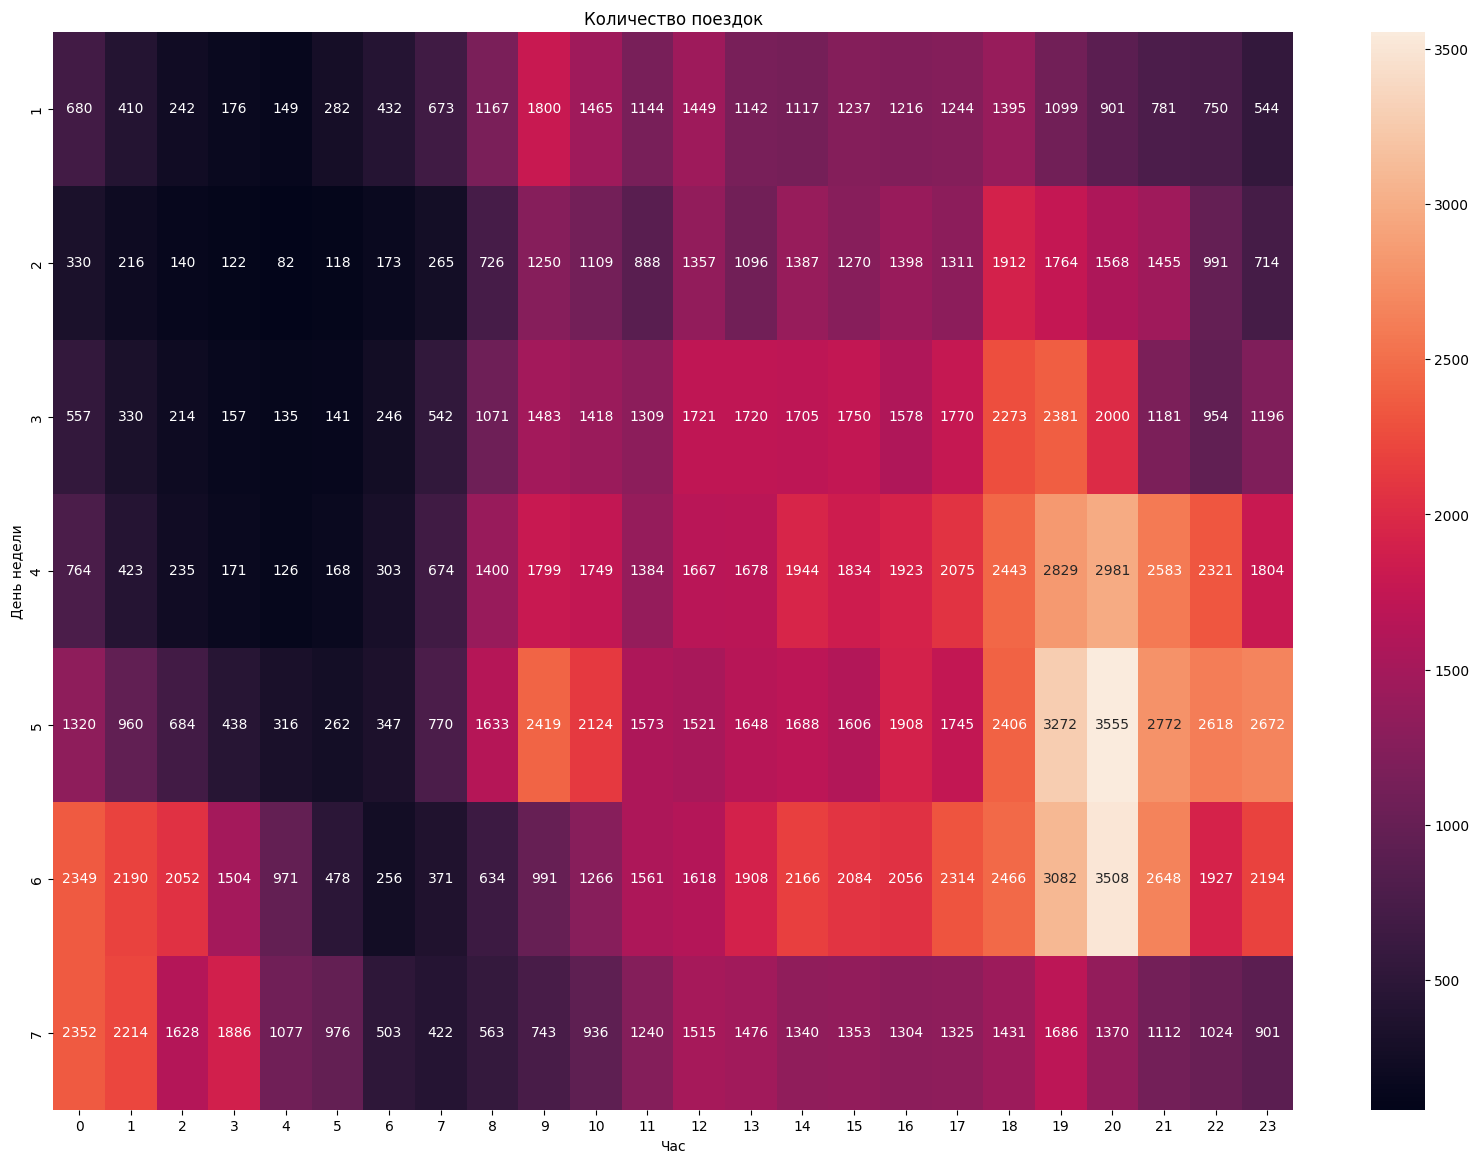

In [158]:
plt.figure(figsize=(20,14))
sns.heatmap(pd.pivot_table(data=df_estimate, index='weekday', columns='hour', values='avg_count_trips'),
            annot=True, fmt='.0f')
plt.title('Количество поездок')
plt.xlabel('Час')
plt.ylabel('День недели');

Если проанализировать тепловую карту, то можно сделать вывод, что:
- периоды поездок ниже среднего: с понедельника по среду с полуночи до 7 утра и с 21 до 23, в четверг и пятницу - с 1 ночи до 7 утра;
- пиковые значения в рамках всей недели приходятся на часы с 18 до 20;
- больше всего заказов приходится на пятницу и субботу;
- в понедельник активность клиентов меньше всего.

### Выручка водителя

In [159]:
df_estimate['total_60'].describe()

count   1,227.00
mean        9.52
std         2.62
min         3.03
25%         7.60
50%         8.85
75%        11.00
max        25.29
Name: total_60, dtype: float64

Исходя из анализа выручки водителя видно, что в среднем за заказ водители получают примерно **9.61** долл., при том, что минимальная составляет **3.95** долл. и медианная - **8.92** долл.

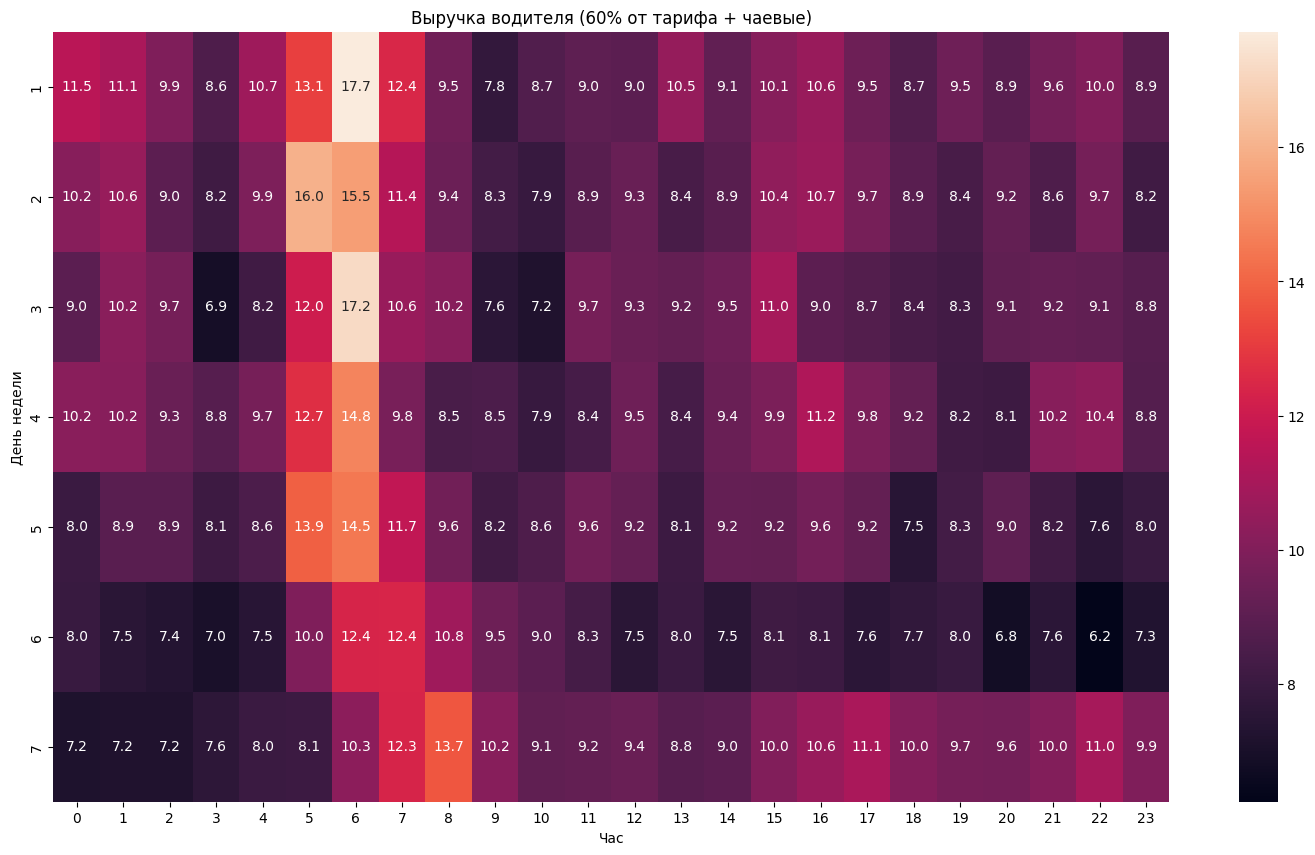

In [160]:
sns.heatmap(pd.pivot_table(data=df_estimate, index='weekday', columns='hour', values='total_60'),
            annot=True, fmt='.1f')
plt.title('Выручка водителя (60% от тарифа + чаевые)')
plt.xlabel('Час')
plt.ylabel('День недели');

По тепловой карте видно, что больше всего выручка в будние дни, особенно в понедельник и вторник, а также воскресенье. В основном самая большая выручка в будние дни приходится на часы с 5 до 7 утра, можно предположить, что чаще всего люди заказывают такси, чтобы добраться до работы или учебного заведения, в выходные самые прибыльные часы с 6 до 9 утра.  
Намного ниже среднего выручка водителей была в субботу, а также в воскресенье с полуночи до 5 утра.  
Можно заметить тенденцию, что начиная с пятницы и до воскресенья с полуночи до 4 утра меньше всего выручки.

### Чаевые

In [161]:
df_estimate['avg_tips'].describe()

count   1,409.00
mean        1.09
std         1.64
min         0.00
25%         0.00
50%         0.00
75%         2.89
max         9.15
Name: avg_tips, dtype: float64

Видно, что в среднем за заказ водители получают примерно **1.14** долл. в качестве чаевых, при том, что максимальная сумма составляет **9.15** долл., но в основном они получают не более **2.98** долл.

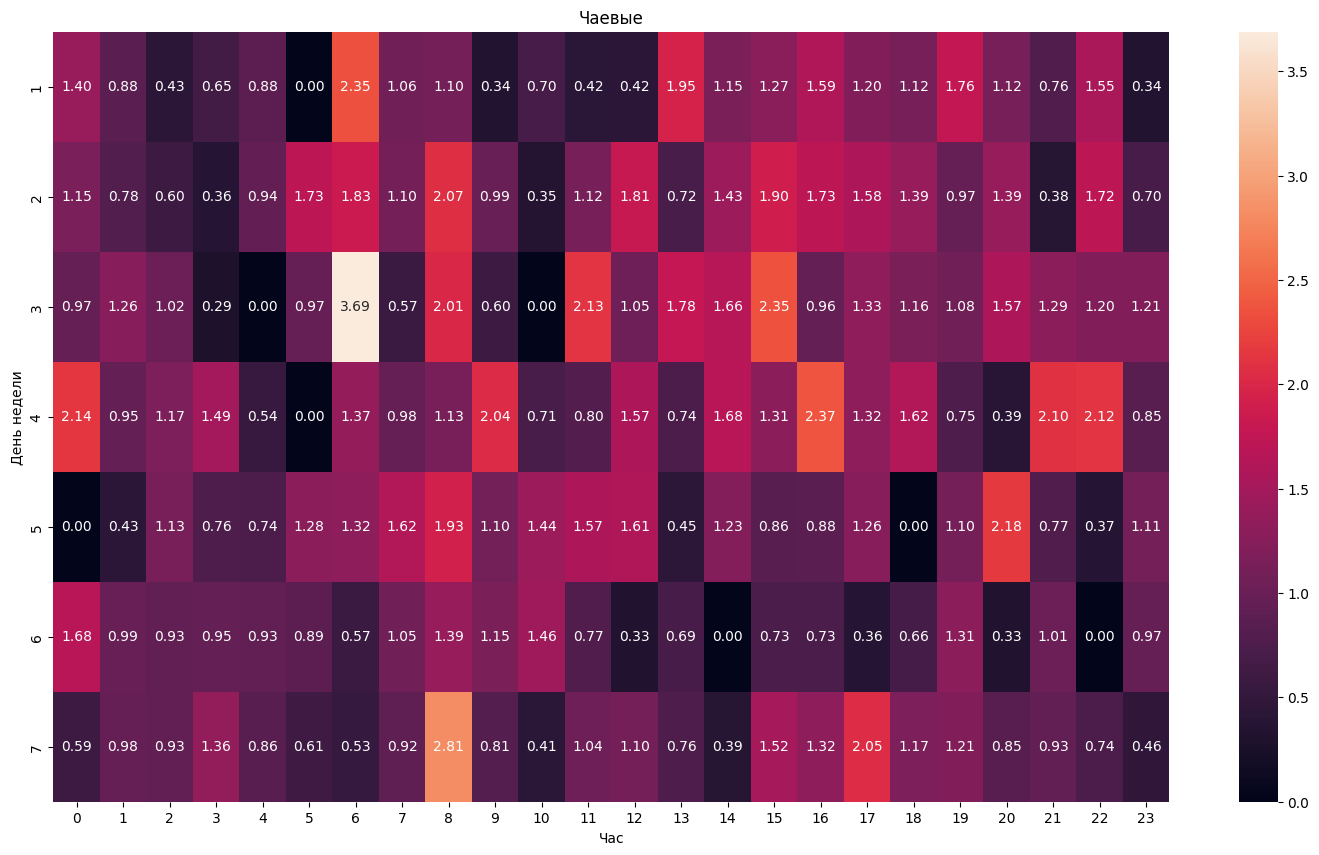

In [162]:
sns.heatmap(pd.pivot_table(data=df_estimate, index='weekday', columns='hour', values='avg_tips'),
            annot=True, fmt='.2f')
plt.title('Чаевые')
plt.xlabel('Час')
plt.ylabel('День недели');

По тепловой карте видно, что больше всего чаевых водители получают в будние дни, особенно в понедельник и четверг, в выходные чаевые зачастую меньше 1 доллара. В основном самые большие чаевые приходятся с 14 до 19 часов, можно предположить, что чаще всего люди оставляют чаевые после какой-то встречи в дневное время, либо когда они спешат на какое-то праздное событие в вечернее время. Самые маленькие чаевые приходятся на субботу, что можно объяснить тем, что самые щедрые клиенты в эти дни отдыхают вне города или проводят время с семьей.

### Покрытие машин на линии

In [163]:
df_estimate['estimated_coverage'].describe()

count   1,413.00
mean        0.73
std         0.08
min         0.00
25%         0.71
50%         0.73
75%         0.76
max         1.00
Name: estimated_coverage, dtype: float64

Трудно сказать, какой % покрытия можно считать нормой, т.к. все зависит от амбиций и стратегии развития конкретной компании. Если они хотят покрыть как можно больше заказов, то нормой следует считать минимум 80% и в лучшем случае - 90%, такой подход предполагает динамическое формирование %, который получает водитель в зависимости от спроса на такси. Если говорить о компании, которая просто хочет удовлетворить большинство клиентов или в рамках нормы по городу, то наверное таким значением можно считать 70%.

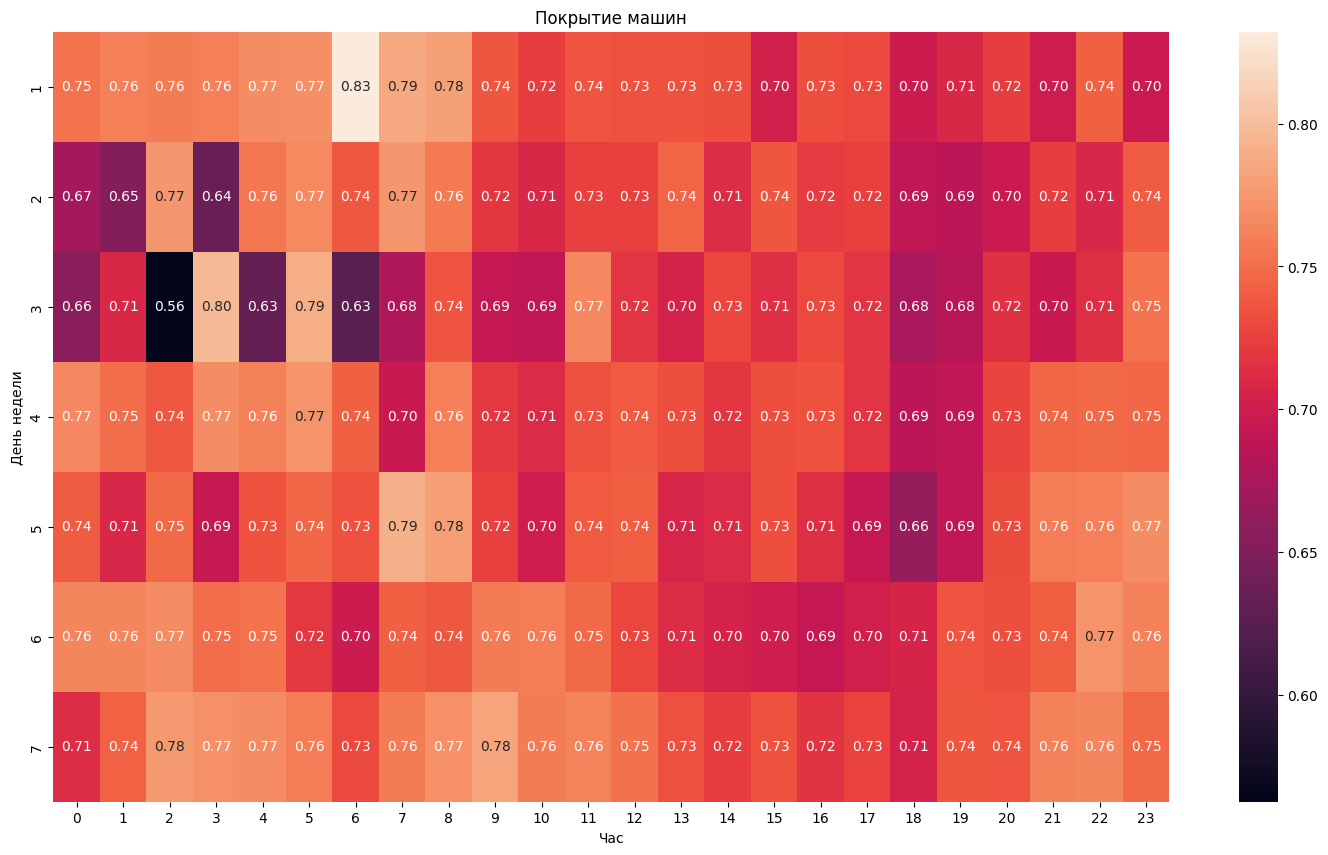

In [164]:
sns.heatmap(pd.pivot_table(data=df_estimate, index='weekday', columns='hour', values='estimated_coverage'),
            annot=True, fmt='.2f')
plt.title('Покрытие машин')
plt.xlabel('Час')
plt.ylabel('День недели');

Тепловая карта имеет довольно равномерное покрытие, практически все дни и часы держатся в районе 70%, иногда проседая до 68-69%.
Если сопоставить карту покрытия с количеством поездок, то стоит принять меры, увеличив предложение во вторник в целом, и в будние дни с 18 до 19 часов, но это лишь по предварительным оценкам, т.к. стоит рассмотреть именно количество нужного обхема машин на линии, когда был избыток спроса, который не покрывало текущее предложение.

### Дефицит количества машин на линии

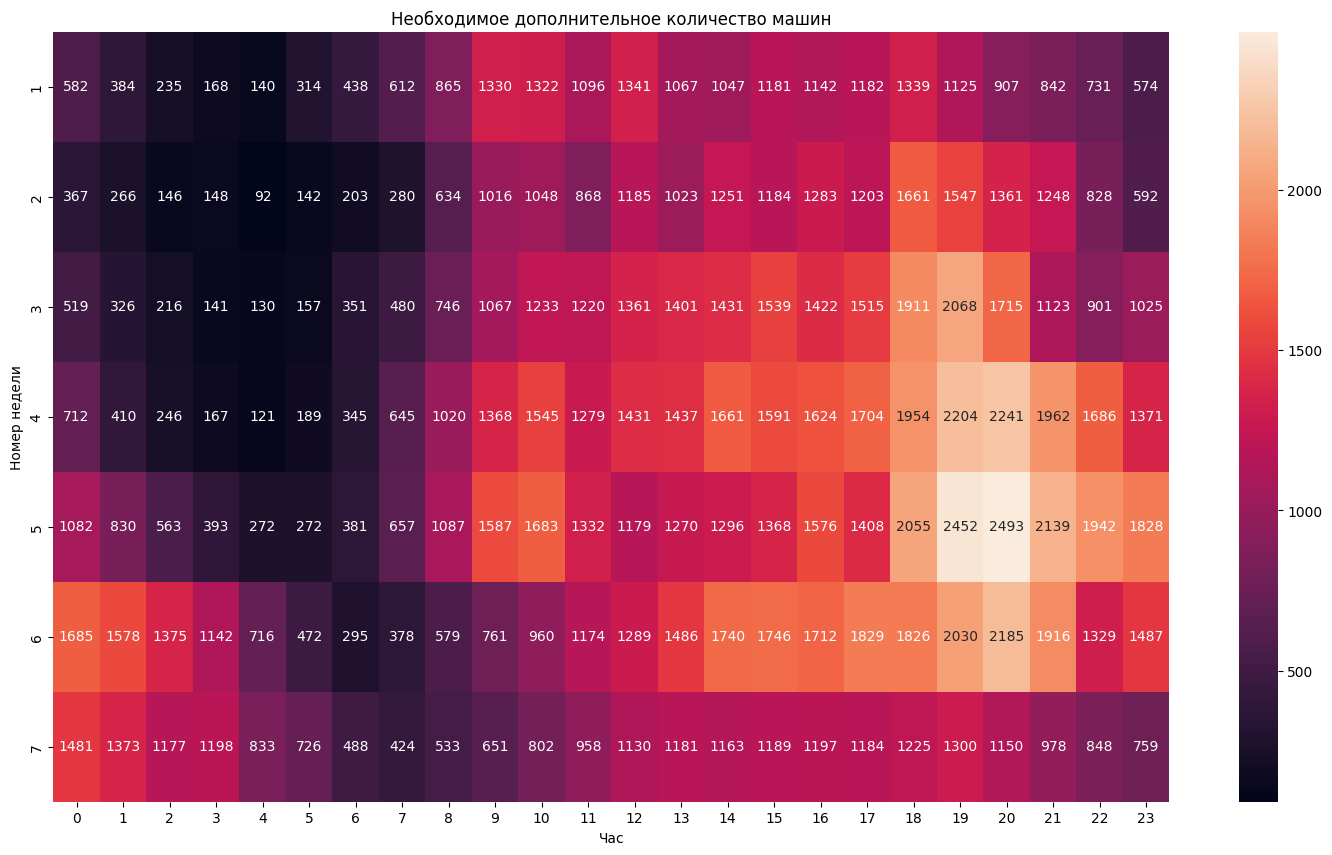

In [165]:
sns.heatmap(pd.pivot_table(data=df_estimate, index='weekday', columns='hour', values='required_cars'),
            annot=True, fmt='.0f')
plt.title('Необходимое дополнительное количество машин')
plt.xlabel('Час')
plt.ylabel('Номер недели');

Если проанализировать тепловую карту, то можно сделать вывод, что:
- с понедельника по среду с полуночи до 7 утра и с 21 до 23, в четверг и пятницу - с 1 ночи до 7 утра не хватает небольшого количества машин, т.е. в них нет острой необходимости;
- пиковые значения в рамках всей недели приходятся на часы с 18 до 20;
- больше всего нужно дополнительных машин в четверг и пятницу - с 10 до 23, и в субботу практически на протяжении всего дня, за исключением периода с 5 до 9 утра;
- в выходные чувствуется явная нехватка машин с полуночи до 4 ночи.

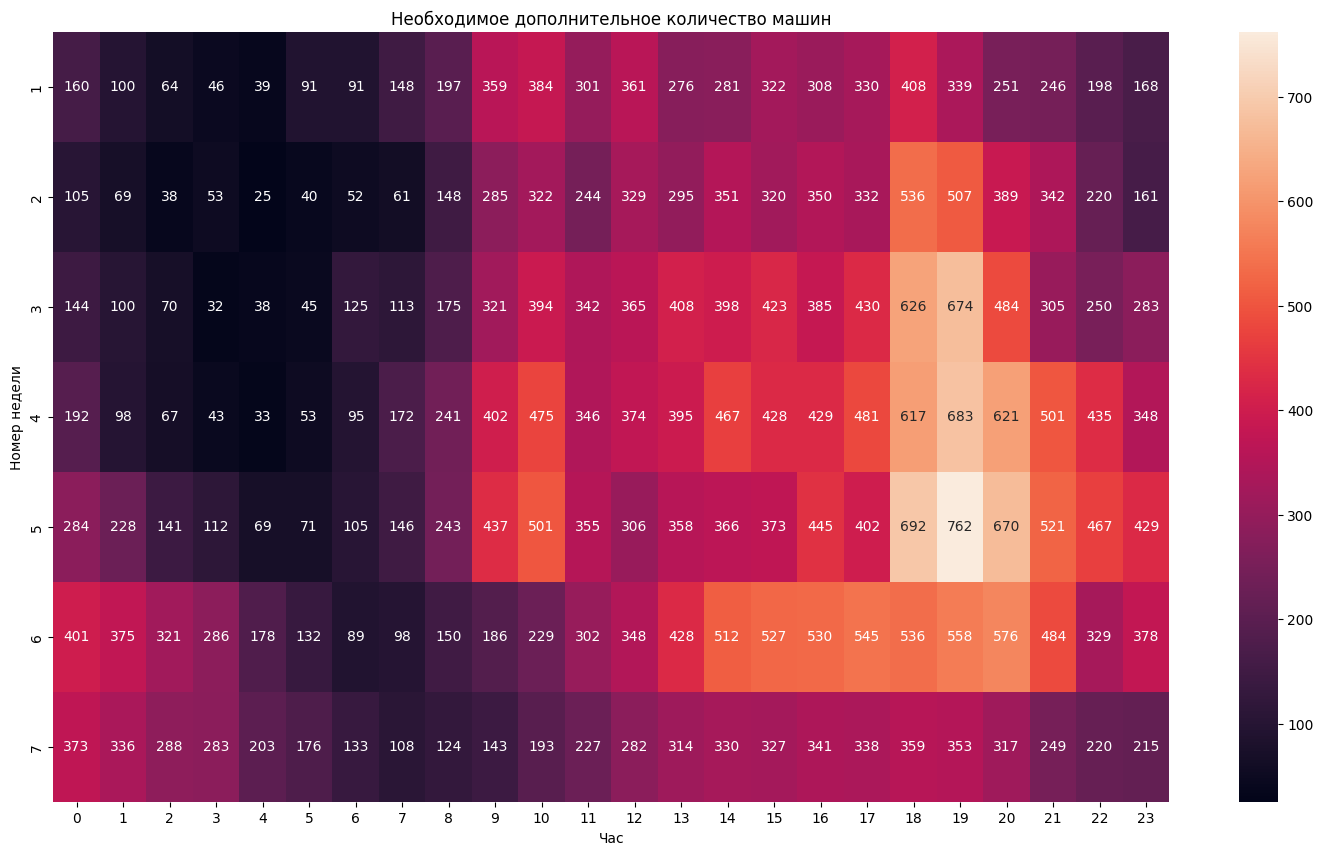

In [166]:
#необходимое количество машин для обеспечения 100% покрытия. Считаем дельту - от количества машин, которое нужно, отнимаем количество машин, которое уже есть на линии
delta = df_estimate.required_cars - df_estimate.avg_count_cars
sns.heatmap(pd.pivot_table(data=df_estimate.join(delta.to_frame()), index='weekday', columns='hour', values=(0)),
            annot=True, fmt='.0f')
plt.title('Необходимое дополнительное количество машин')
plt.xlabel('Час')
plt.ylabel('Номер недели');

### Объём недополученной общей выручки

In [167]:
df_estimate['lost_profit'].describe()

count    1,286.00
mean    15,907.16
std     10,592.61
min          9.45
25%      6,290.72
50%     15,857.58
75%     24,089.80
max     43,509.30
Name: lost_profit, dtype: float64

В среднем (при 100% обеспечении предложения) потеря прибыли составляет **15 710** долл., максимальные потери могут достигать **44 780** долл. в час.

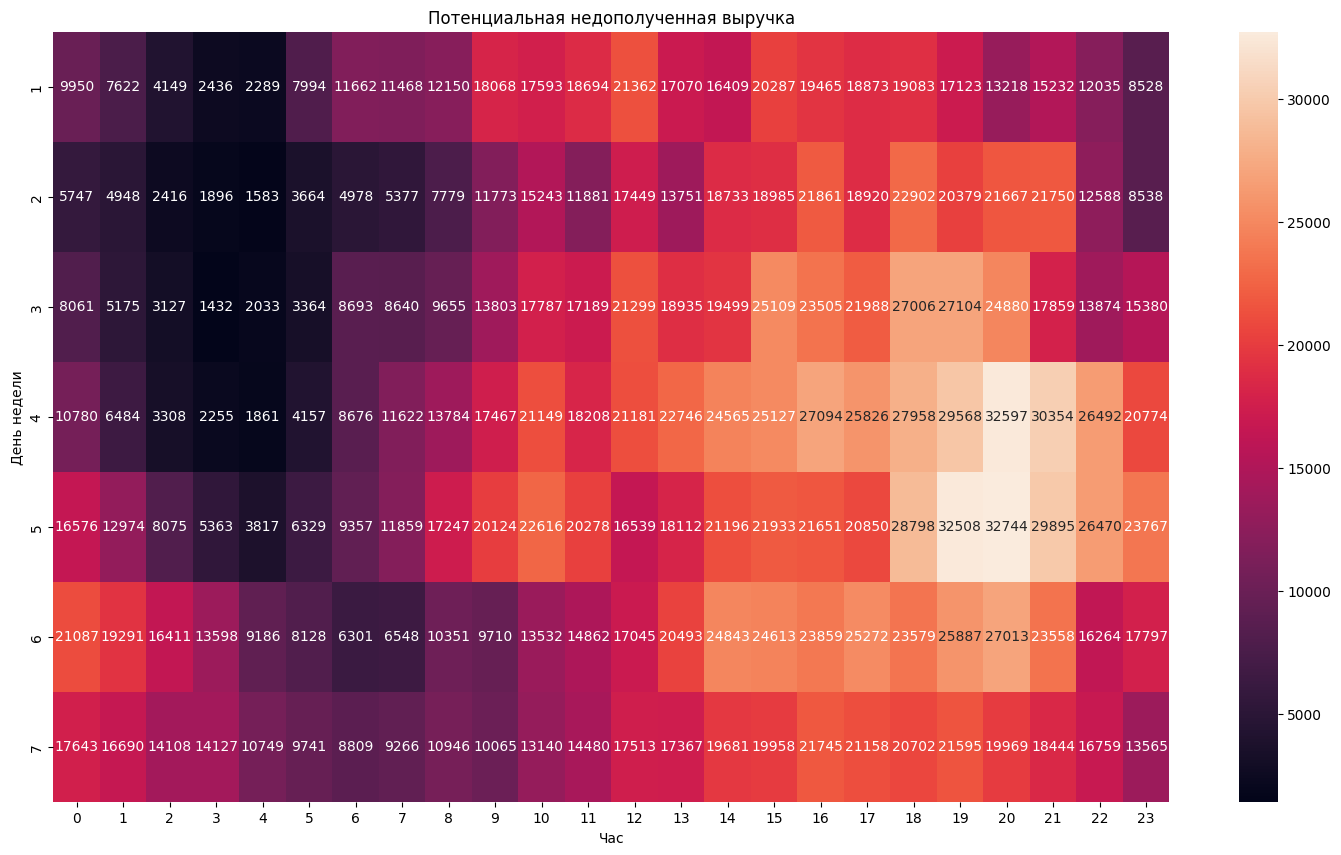

In [168]:
sns.heatmap(pd.pivot_table(data=df_estimate, index='weekday', columns='hour', values='lost_profit'),
            annot=True, fmt='.0f')
plt.title('Потенциальная недополученная выручка')
plt.xlabel('Час')
plt.ylabel('День недели');

Если проанализировать тепловую карту, то можно сделать вывод, что:
- в будние дни с 3 ночи до 5 утра недополученная выручка меньше всего, а в выходные лишь в 5 и 7 утра;
- в будние дни в 10, 12 и с 14 до 20 недополученная выручка больше всего, а в выходные на протяжении почти все второй половины дня;
- больше всего выручки недополучено со среды по пятницу - с 10 до 23, и в субботу практически на протяжении всего дня, за исключением периода с 5 до 9 утра.

### Вывод

Резюмируя анализ можно выделить следующие ключевые моменты:
- в среднем (при 100% обеспечении предложения) потеря прибыли составляет 15 710 долл., максимальные потери могут достигать 44 780 долл. в час;
- больше всего заказов приходится на пятницу и субботу;
- в понедельник активность клиентов меньше всего;
- самые прибыльные часы в будние дни для водителя с 5 до 7 утра, в выходные - с 6 до 9 утра;
- в будние дни cамые большие чаевые приходятся с 14 до 19 часов, самые маленькие чаевые приходятся на субботу;
- больше всего ощущается нехватка машин в рамках всей недели в часы с 18 до 20;
- в будние дни в 10, 12 и с 14 до 20 недополученная выручка больше всего, а в выходные на протяжении почти все второй половины дня.

### Рекомендации

Исходя из этих тезисов в главе `3.7`можно принять решение, что следует увеличить количество машин с 14 до 19 часов. Простимулировать данную нехватнку можно разными способами:
1. Ввести динамические % выручки для водителя, который формируется в зависимости от роста спроса - это поможет сократить суммы недополученной выручки компании.
2. Если компания хочет нарастить влияние в данной сфере и заслужить лояльность клиентов, то возможно стоит увеличить % для водителей в рамках промо.
3. Также стоит рассмотреть систему поощрений для водителей, которые берут заказы в часы с повышенным спросом, предоставляя им периоды (в виде часов или одного дня), когда они получают 90% или даже 100% от всего тарифа.

Более подробно расписывать данные рекомендации нет смысла, т.к. в ходе проекта не было предоставлено алгоритмов для рассчета динамических тарифов водителей, также не имеет смысла рассчитывать потенциальную прибыль при данном стимулировании, т.к. у каждой компании свои ресурсы и нельзя подогнать данные рекомендации ко всему проекту, не зная деталей и других вводных каждой компании.

<a href="https://disk.yandex.ru/i/o9xkg1_9QM9BMw">Презентация</a>